In [1]:
%cd /home/schirrmr/

%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('DEBUG')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)
seaborn.set_palette('colorblind')

/home/schirrmr


In [2]:
import os
# add the repo itself
os.sys.path.insert(0, '/home/schirrmr/code/explaining/reversible//')

In [3]:
import pickle
import gzip
## from  http://deeplearning.net/data/mnist/mnist.pkl.gz I assume?
train, val, test = pickle.load(gzip.open('data/mnist/mnist.pkl.gz'), encoding='bytes')

X_train, y_train = train
X_val, y_val = val

X_train_topo = X_train.reshape(X_train.shape[0], 1, 28,28)
X_val_topo = X_val.reshape(X_val.shape[0], 1, 28,28)
from numpy.random import RandomState
#X_train_topo = np.pad(X_train_topo,((0,0),(0,0),(2,2),(2,2)), 'constant')
#X_val_topo = np.pad(X_val_topo,((0,0),(0,0),(2,2),(2,2)), 'constant')

In [4]:
from reversible.revnet import ReversibleBlock
import torch.nn as nn
def rev_block(n_chans, n_intermediate_chans):
    c = n_chans // 2
    n_i_c = n_intermediate_chans
    return ReversibleBlock(
        nn.Sequential(
            (nn.Linear(c, n_i_c,)),
             nn.ReLU(),
             nn.Linear(n_i_c, c,)),
        nn.Sequential(
            (nn.Linear(c, n_i_c,)),
             nn.ReLU(),
             nn.Linear(n_i_c, c,)))

def plot_sorted_examples(sorted_examples, cmap=cm.Greys_r, vmin=0,vmax=1):
    fig, axes = plt.subplots(2,10, figsize=(20,5))
    for ax, im in zip(axes.flatten(), sorted_examples.squeeze()):
        ax.imshow(im, vmin=vmin, vmax=vmax,cmap=cmap)
    return fig


In [5]:
mask = (y_train == 0) | (y_train == 1)
x = X_train_topo[mask]#[:1000]
y = y_train[mask]

In [6]:
from reversible.iterator import GenerativeIterator
from reversible.revnet import SubsampleSplitter, ViewAs
from reversible.util import set_random_seeds
from reversible.revnet import init_model_params
import torch as th
set_random_seeds(34093049, True)
feature_model = th.nn.Sequential(
    SubsampleSplitter(stride=2,checkerboard=True),
    ViewAs((-1,4,14,14),(-1,4*14*14)),
    rev_block(784,2000),
    rev_block(784,2000),
    rev_block(784,2000),)
feature_model = feature_model.cuda()
init_model_params(feature_model, 1)

n_dims = int(np.prod(x.shape[1:]))
n_clusters = int(len(np.unique(y)))
means_per_dim = th.autograd.Variable(th.zeros(n_clusters,n_dims).cuda() * 1.0, requires_grad=True)
stds_per_dim = th.autograd.Variable(th.ones(n_clusters,n_dims).cuda()  * 0.5, requires_grad=True)

In [7]:
from reversible.sliced import sample_directions
from reversible.util import np_to_var
directions_adv = th.cat([sample_directions(n_dims, True,True),
                         sample_directions(n_dims, True,True),
                         sample_directions(n_dims, True,True),
                        ],dim=0)
directions_adv = th.autograd.Variable(directions_adv.data, requires_grad=True)

inputs = np_to_var(x, dtype=np.float32).cuda()
targets = np_to_var(np.array([y == 0, y == 1]).T, dtype=np.float32).cuda()

from reversible.training import init_std_mean

init_std_mean(feature_model, inputs, targets, means_per_dim, stds_per_dim,
                 set_phase_interval=True)

optimizer = th.optim.Adam([
    {'params': list(feature_model.parameters()) + 
                       [means_per_dim, stds_per_dim],
    'lr': 0.001},],
{'params':[directions_adv,],
    'lr': -0.001},)

In [8]:
from reversible.training import GenerativeRevTrainer
iterator = GenerativeIterator(upsample_supervised=True, batch_size=10610//8)
trainer = GenerativeRevTrainer(feature_model, optimizer, means_per_dim, stds_per_dim, iterator)


In [9]:
from reversible.sinkhorn import sinkhorn_to_gauss_dist
from reversible.sliced import sliced_from_samples_for_gauss_dist
from reversible.loss_util import hard_loss_per_cluster

hard_loss_fn = lambda o,m,s : (sinkhorn_to_gauss_dist(o,m,s, epsilon=1e-3, stop_threshold=0.001)
                              + 15 * sliced_from_samples_for_gauss_dist(o,m,s,n_dirs=4, adv_dirs=None))
loss_fn = lambda o,d,t,m,s: hard_loss_per_cluster(o,t,m,s, hard_loss_fn)

loss_fn_adv = None # no adversarial training

In [10]:
def train_one_batch(iterator, feature_model, loss_fn, means_per_dim, stds_per_dim,
                   optimizer):
    b = iterator.get_batches(inputs, targets, None, None)
    b_X, b_y = b.__next__()
    outs = feature_model(b_X)
    loss = loss_fn(outs, None, b_y, means_per_dim, stds_per_dim)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = var_to_np(loss)[0]
    return loss

In [11]:
n_batches_per_dataset = len([b for b in iterator.get_batches(inputs, targets, None, None)])
n_critic_updates = 0
n_updates_per_epoch = int(np.ceil(n_batches_per_dataset / (n_critic_updates + 1.0)))

total_loss
0   11.708359

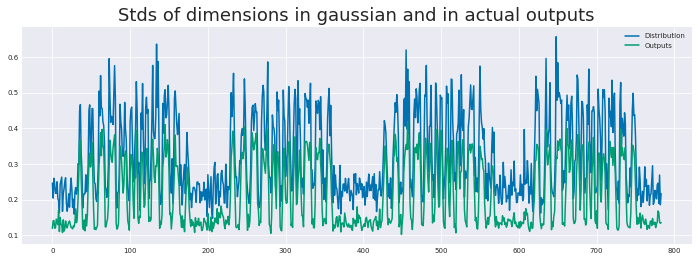

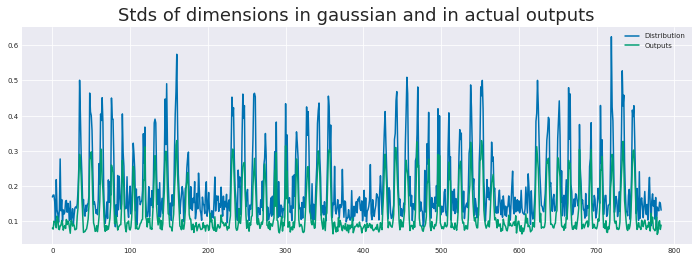

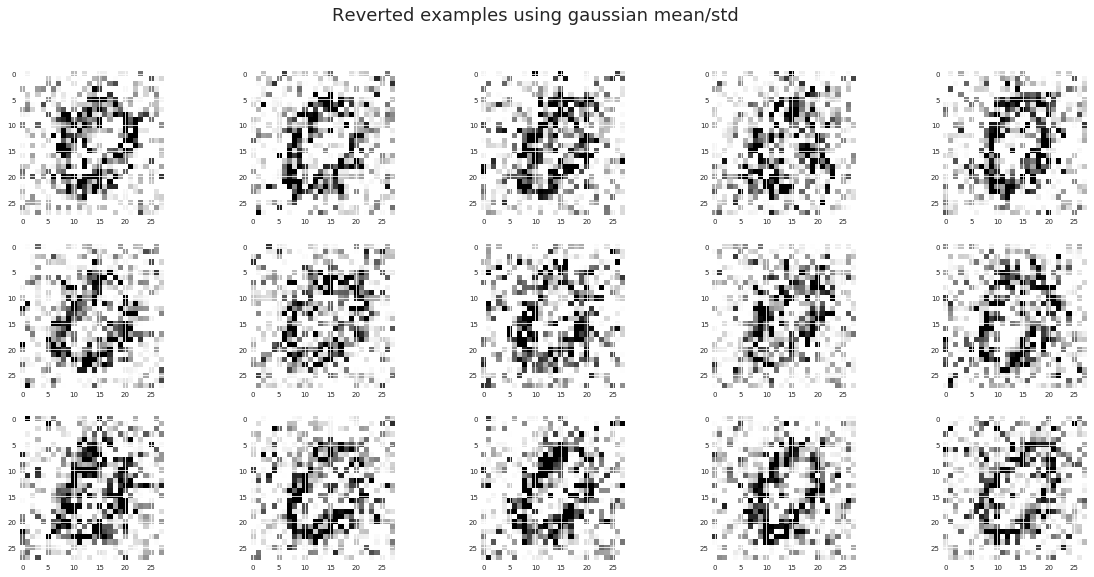

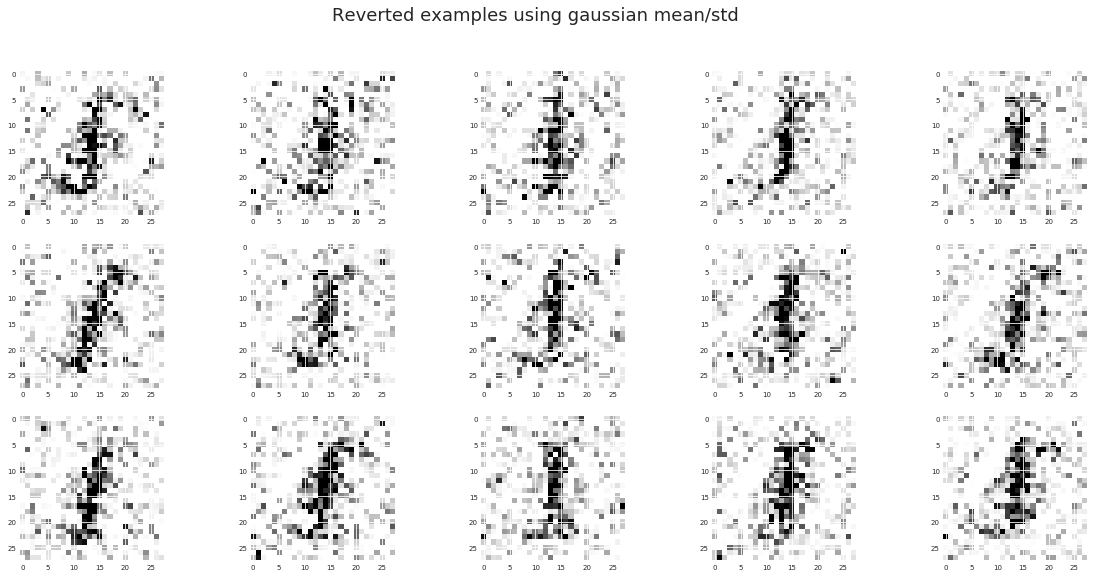

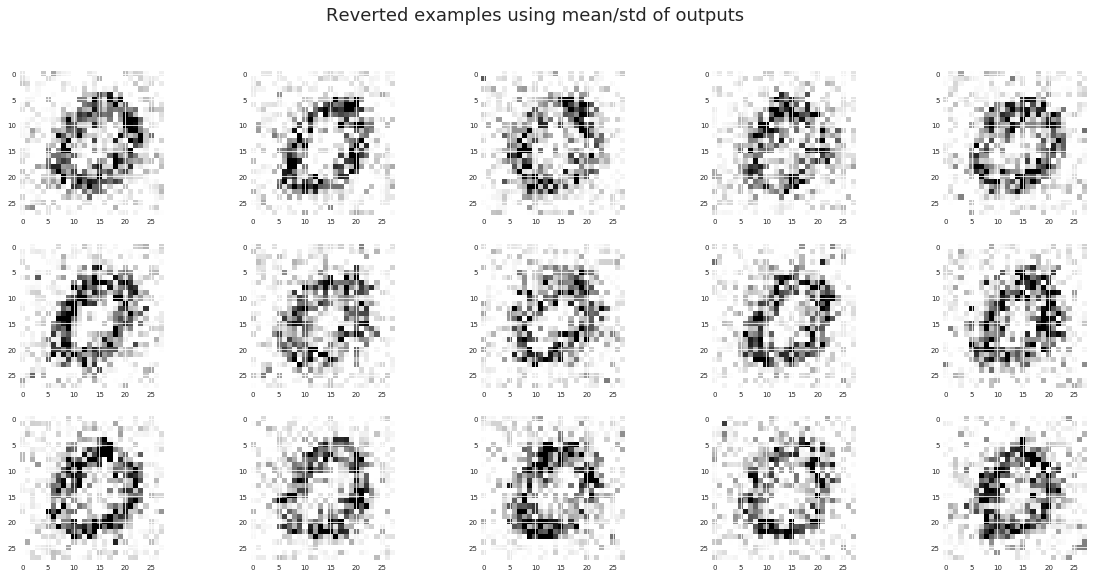

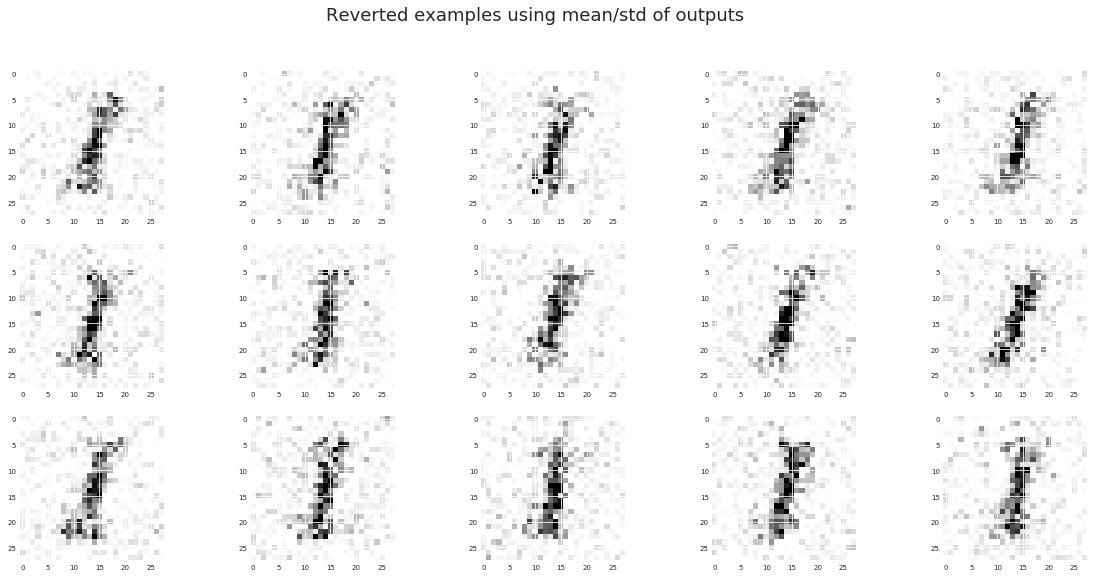

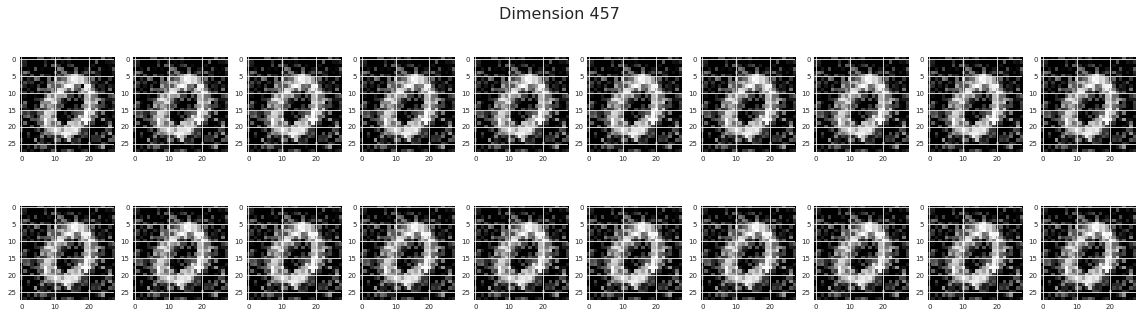

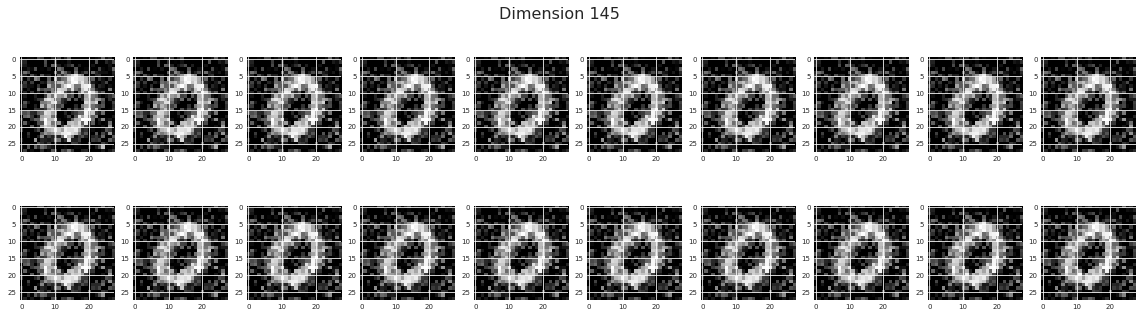

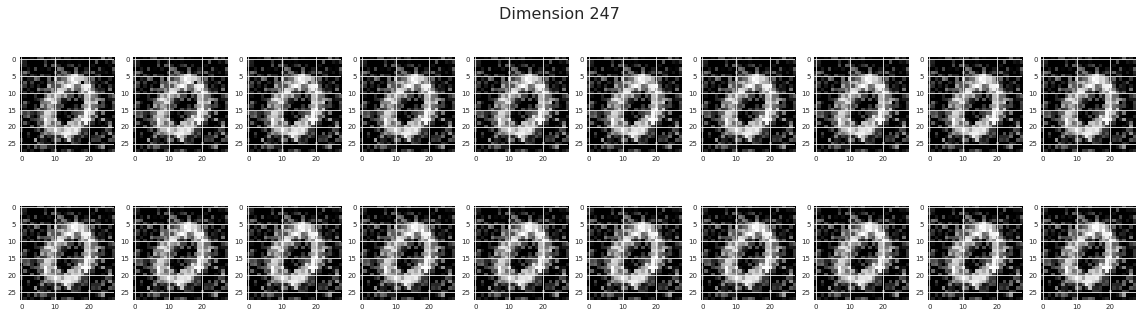

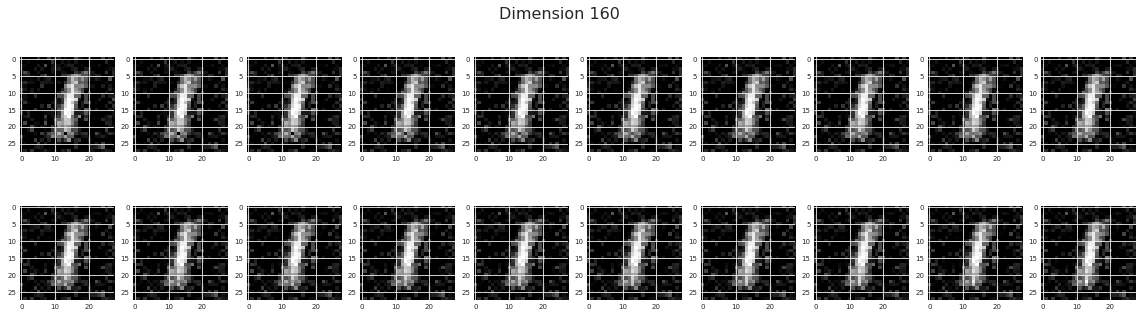

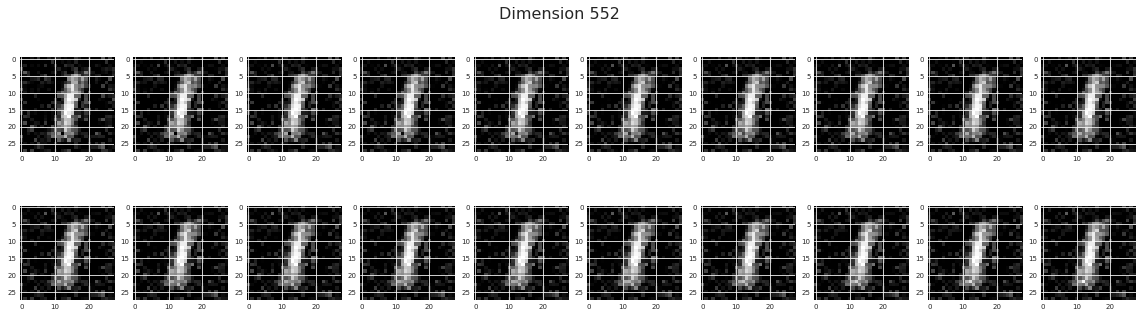

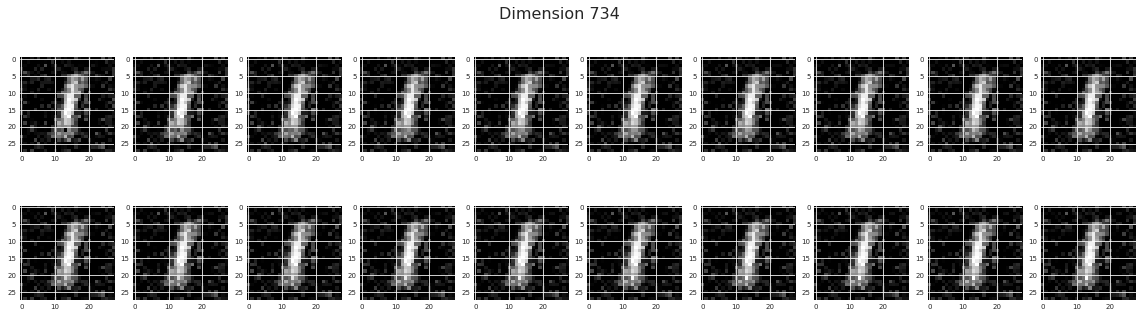

total_loss
10     7.34084

total_loss
20    5.109757

total_loss
30    3.678664

total_loss
40    3.022992

total_loss
50    2.598748

total_loss
60    2.314542

total_loss
70     2.17599

total_loss
80    1.905231

total_loss
90    1.787283

total_loss
100    1.637495

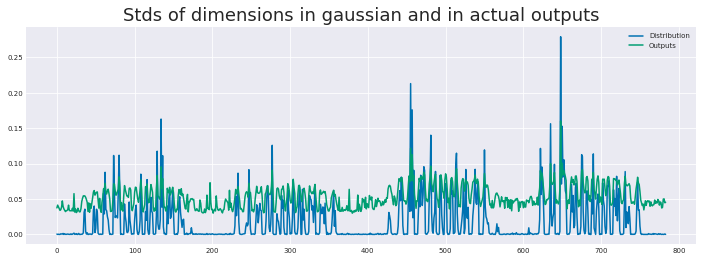

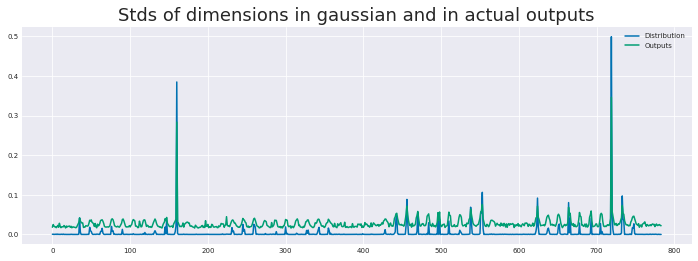

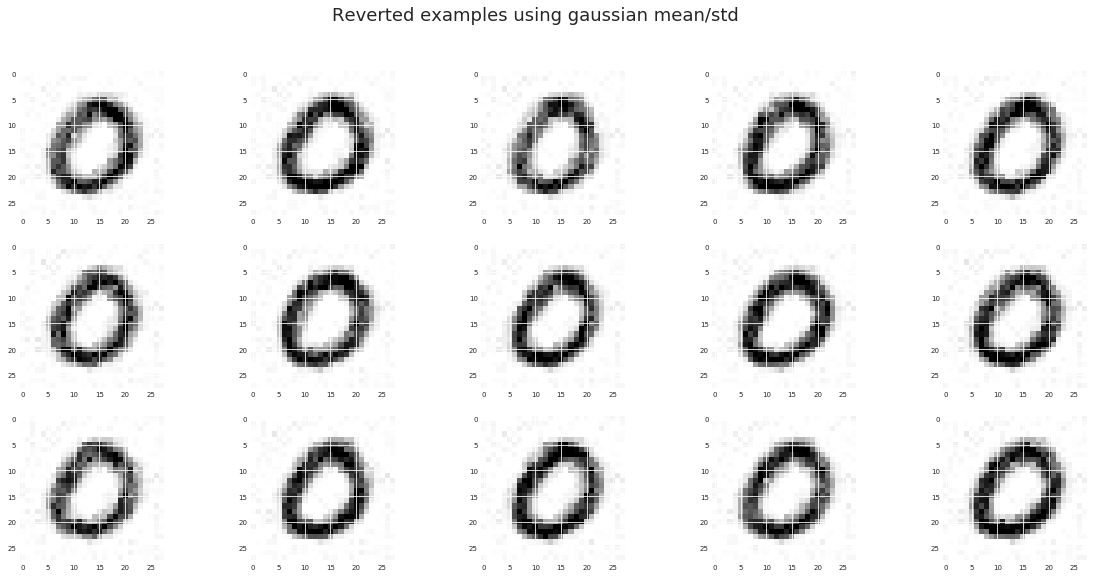

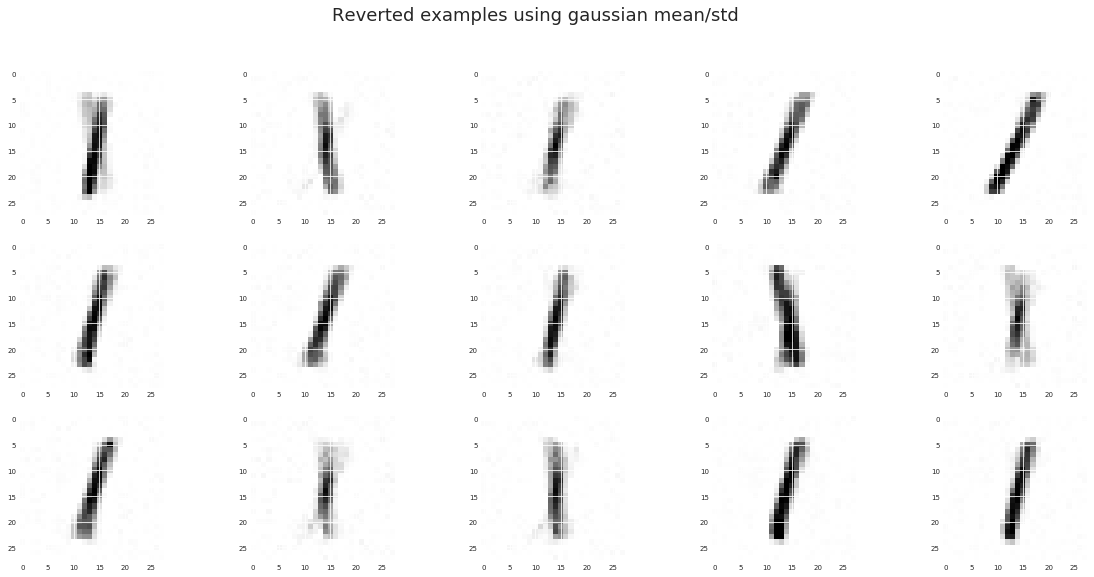

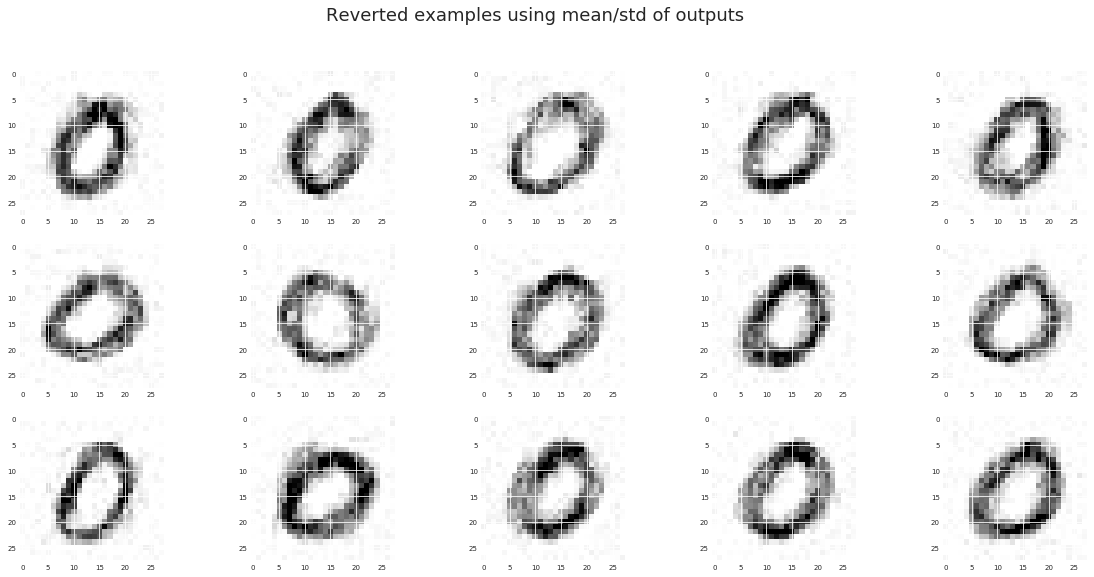

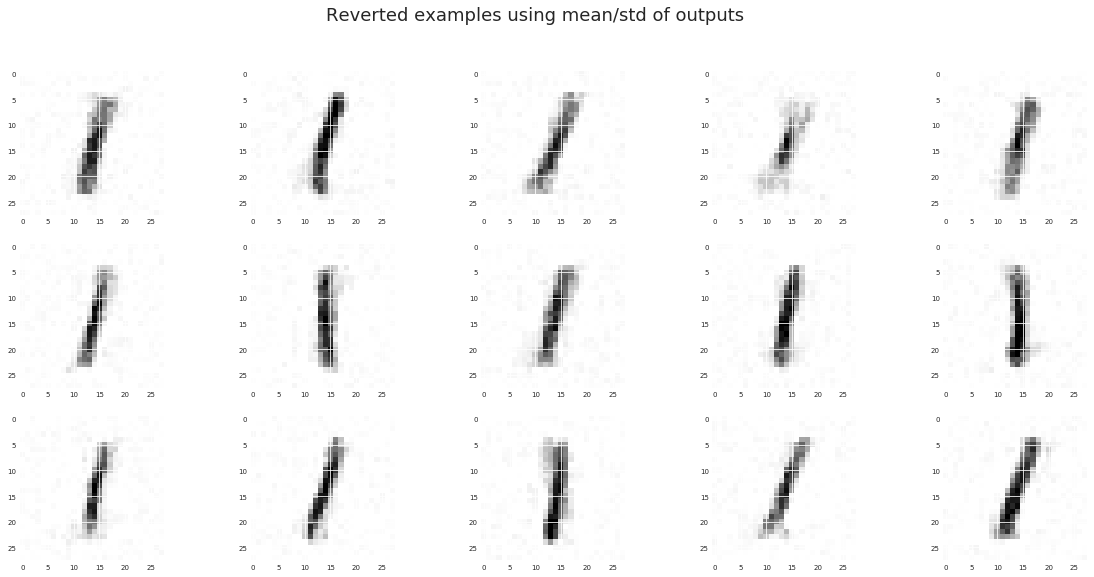

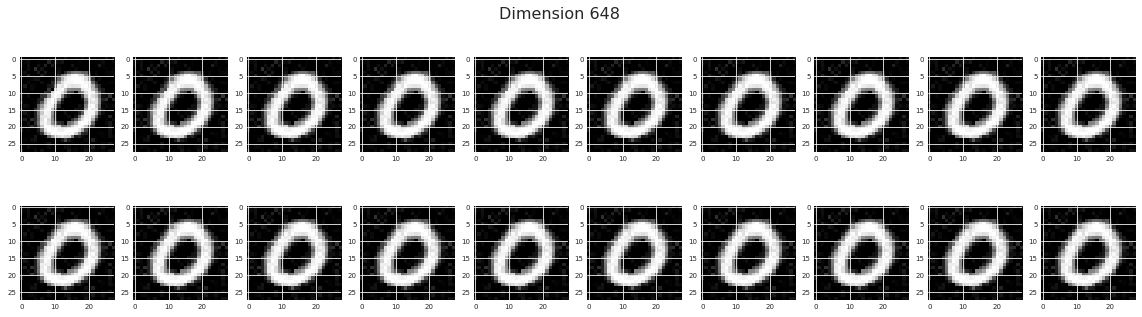

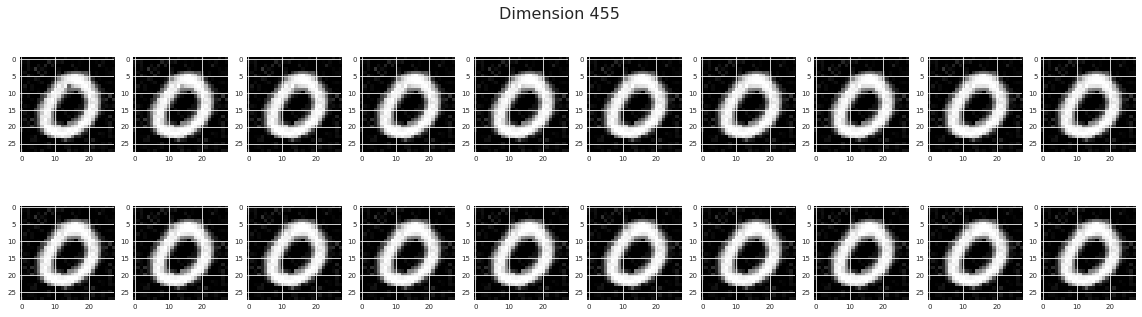

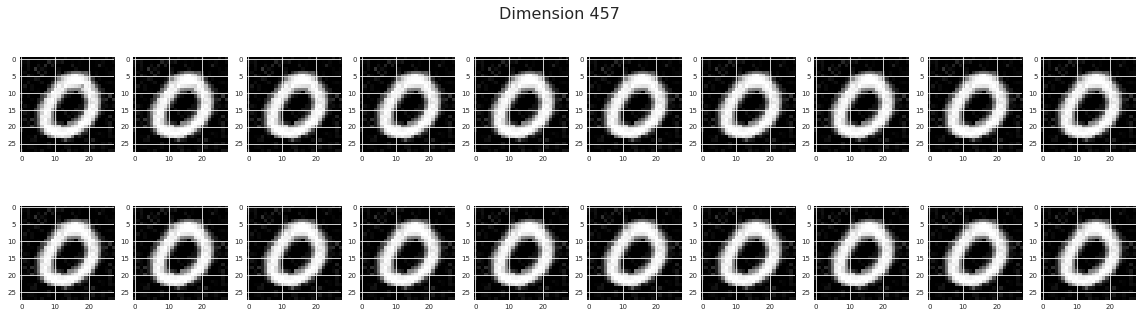

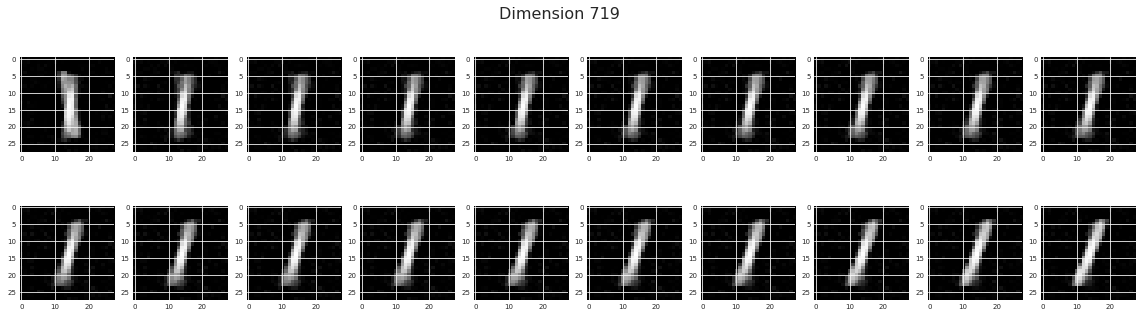

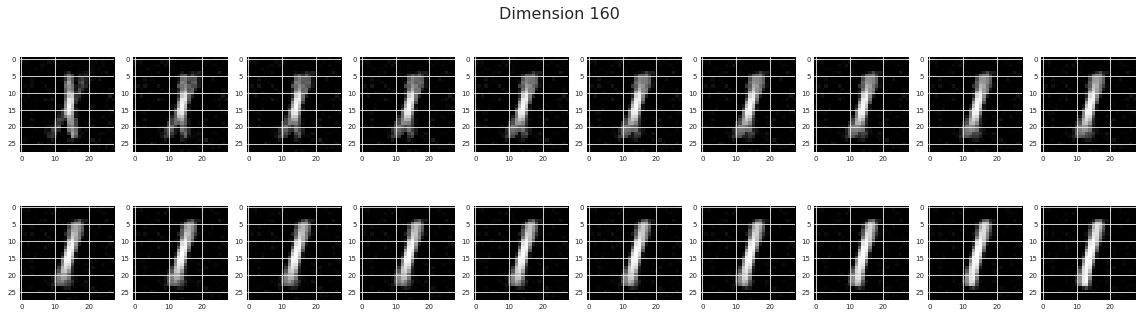

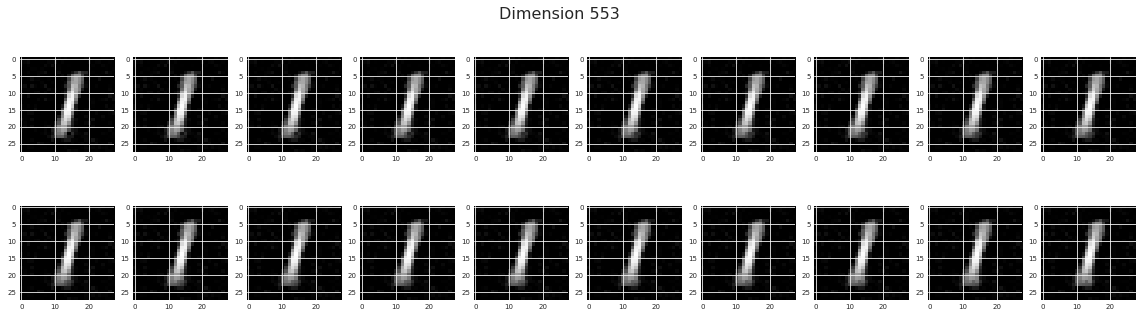

total_loss
110    1.634214

total_loss
120     1.43531

total_loss
130    1.399187

total_loss
140    1.348839

total_loss
150    1.402686

total_loss
160    1.188807

total_loss
170    1.134235

total_loss
180     1.11035

total_loss
190    1.106782

total_loss
200    1.137758

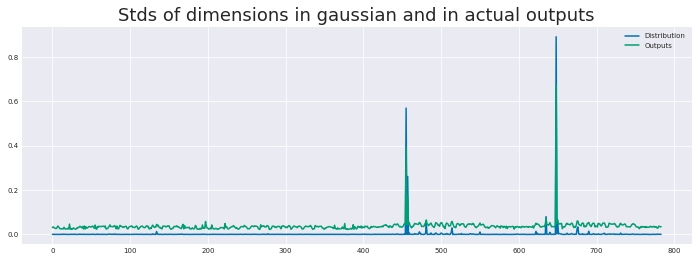

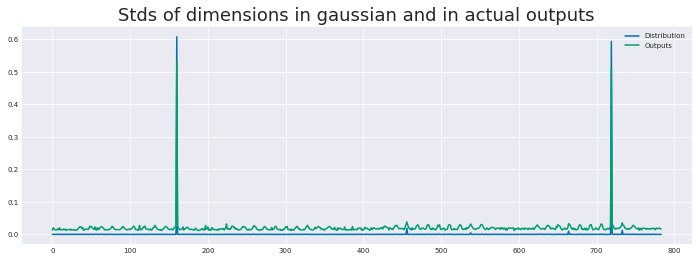

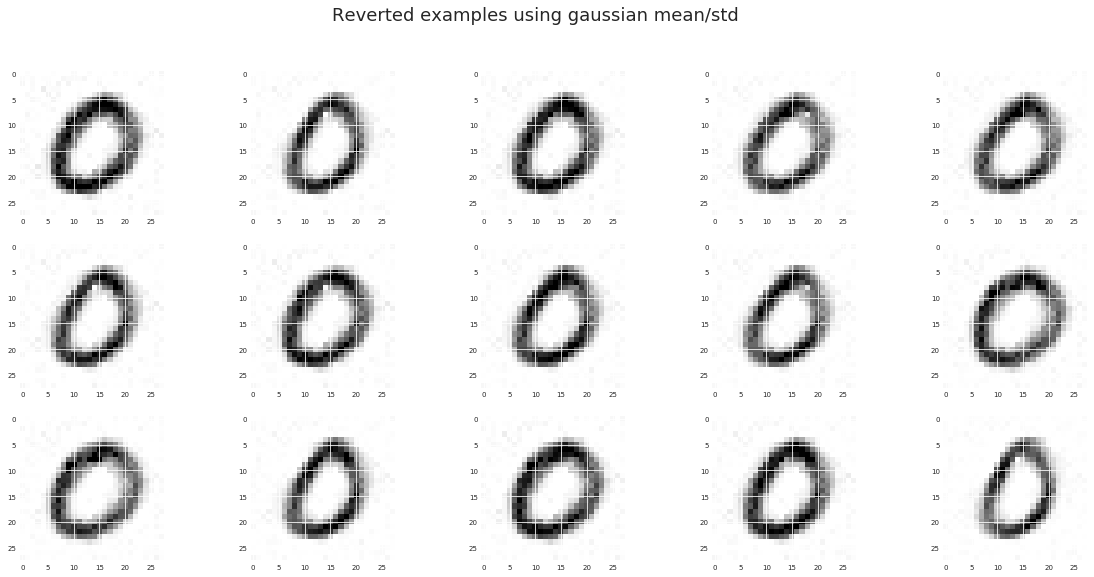

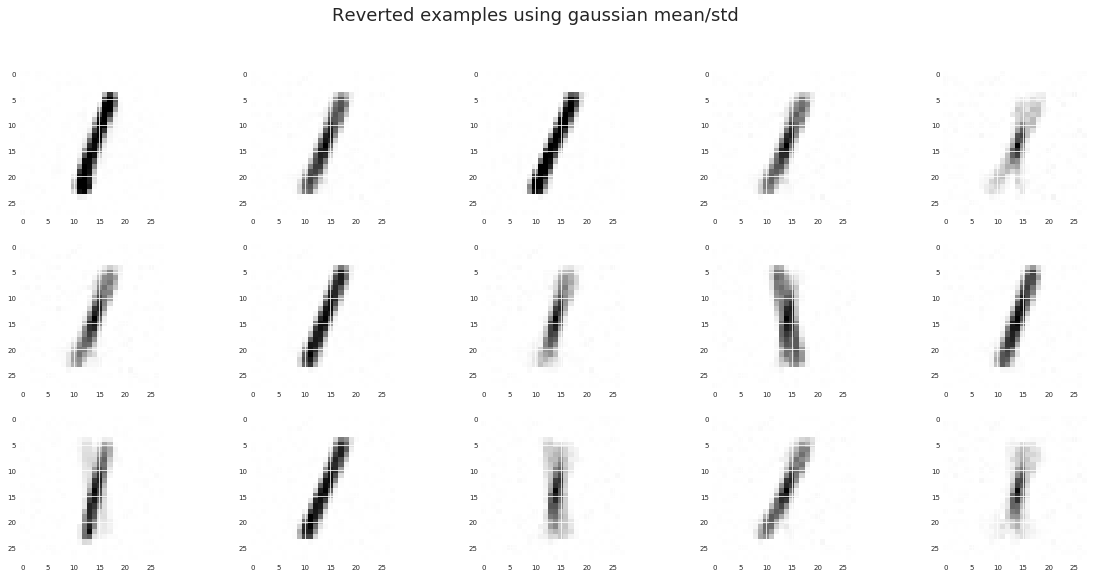

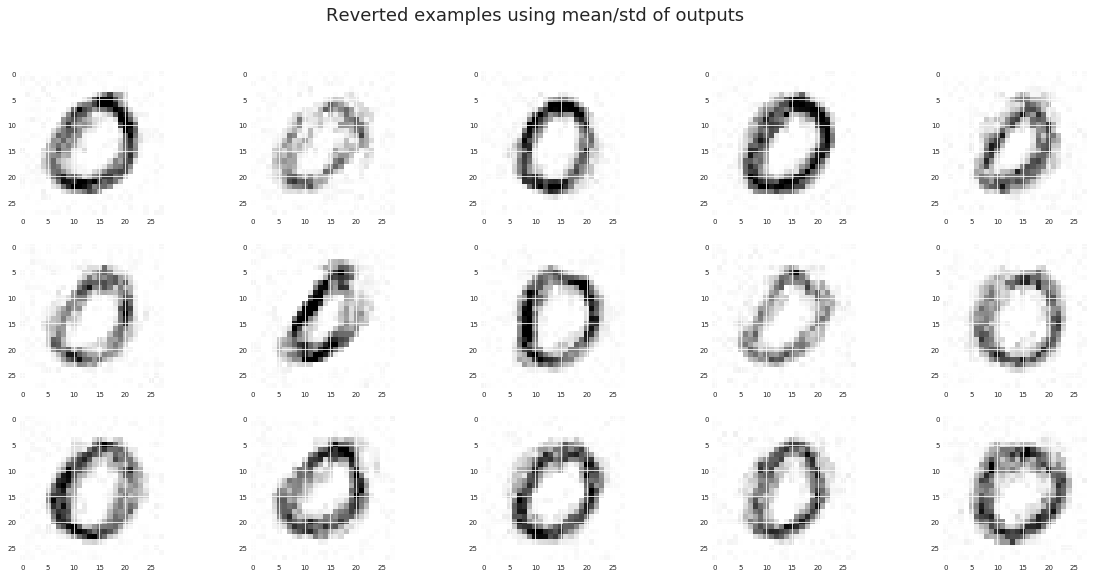

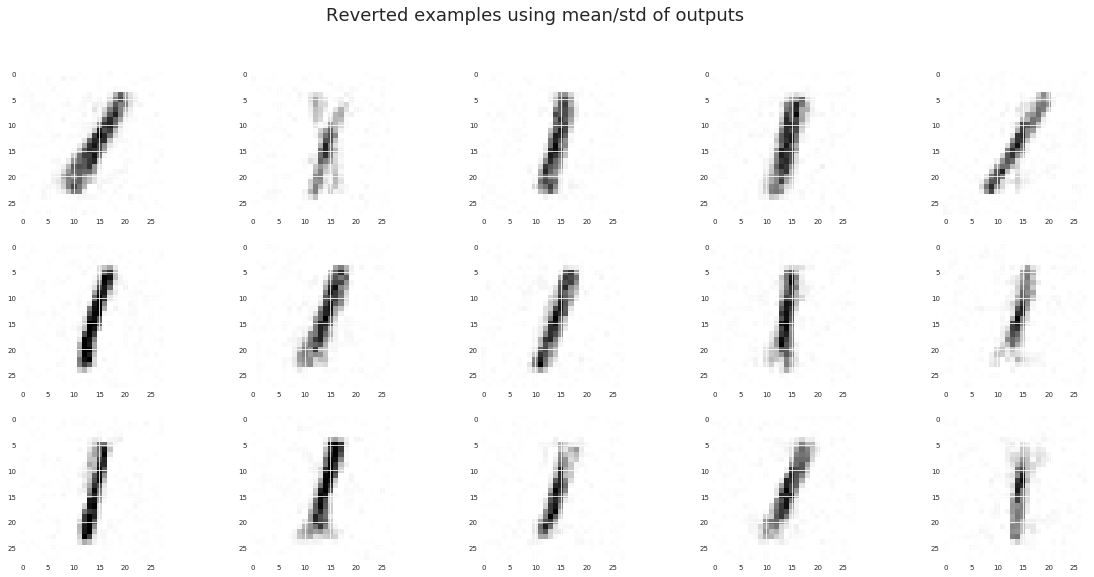

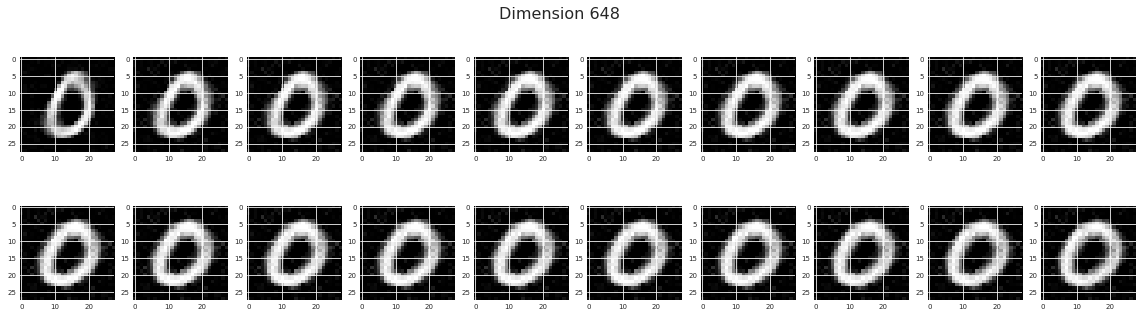

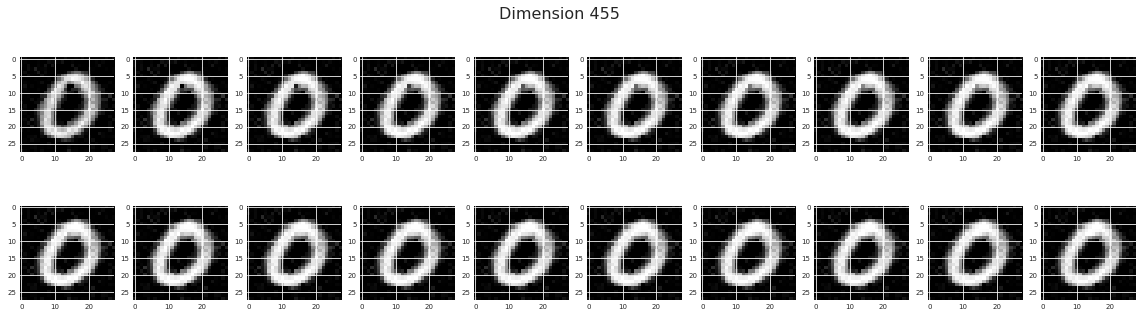

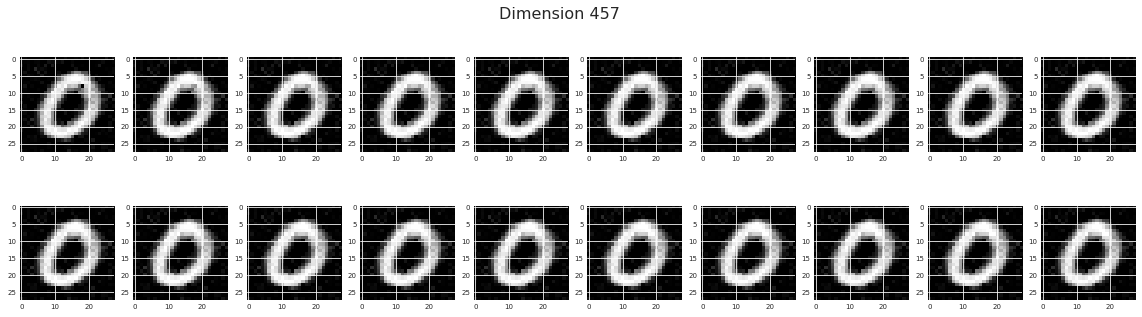

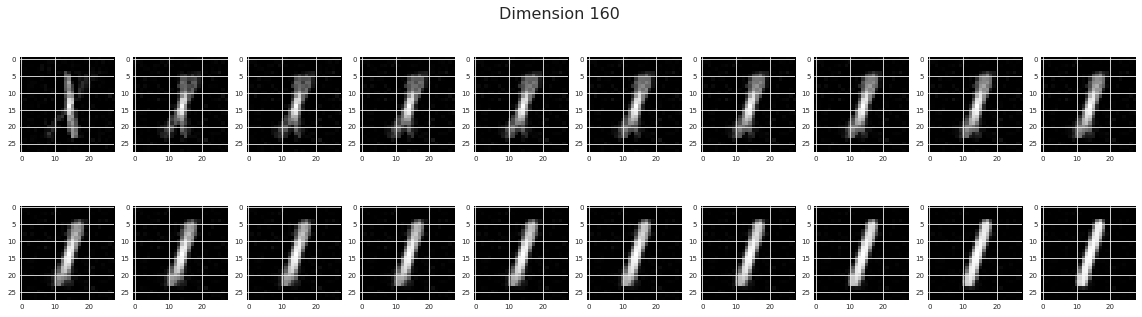

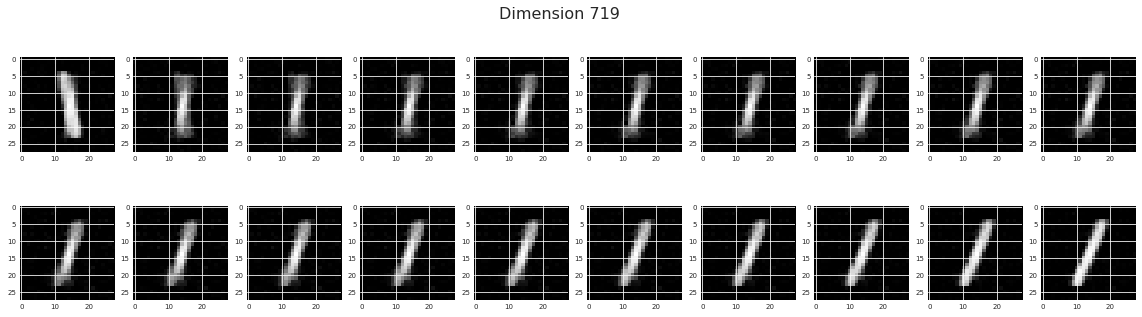

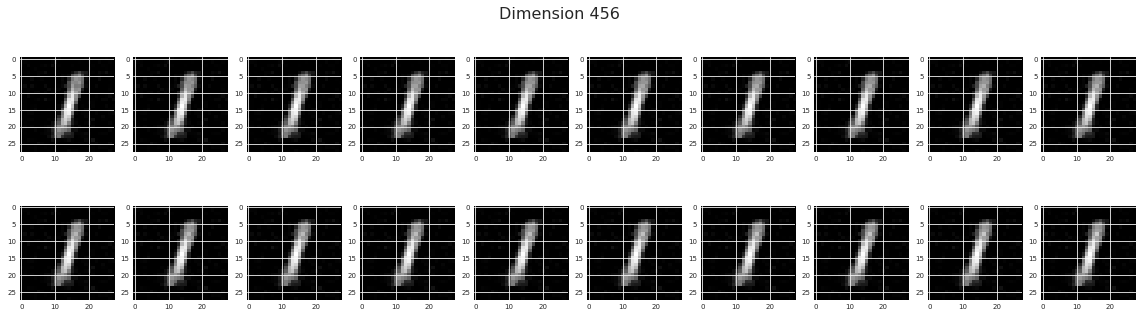

total_loss
210    1.009883

total_loss
220    0.992932

total_loss
230    0.999274

total_loss
240    2.019978

total_loss
250    0.975664

total_loss
260    0.907165

total_loss
270    0.929183

total_loss
280    0.878657

total_loss
290    1.088342

total_loss
300    0.823093

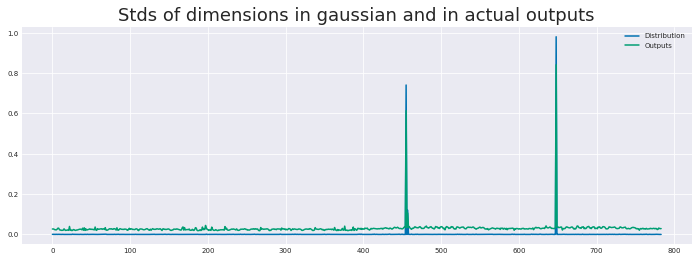

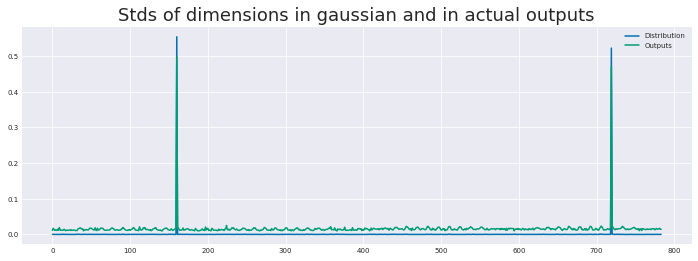

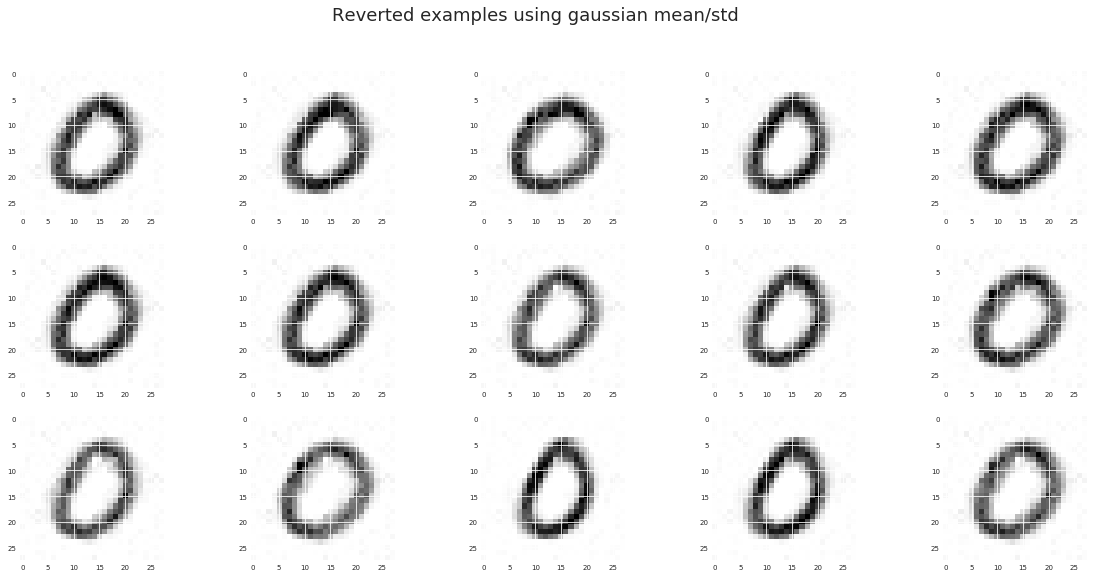

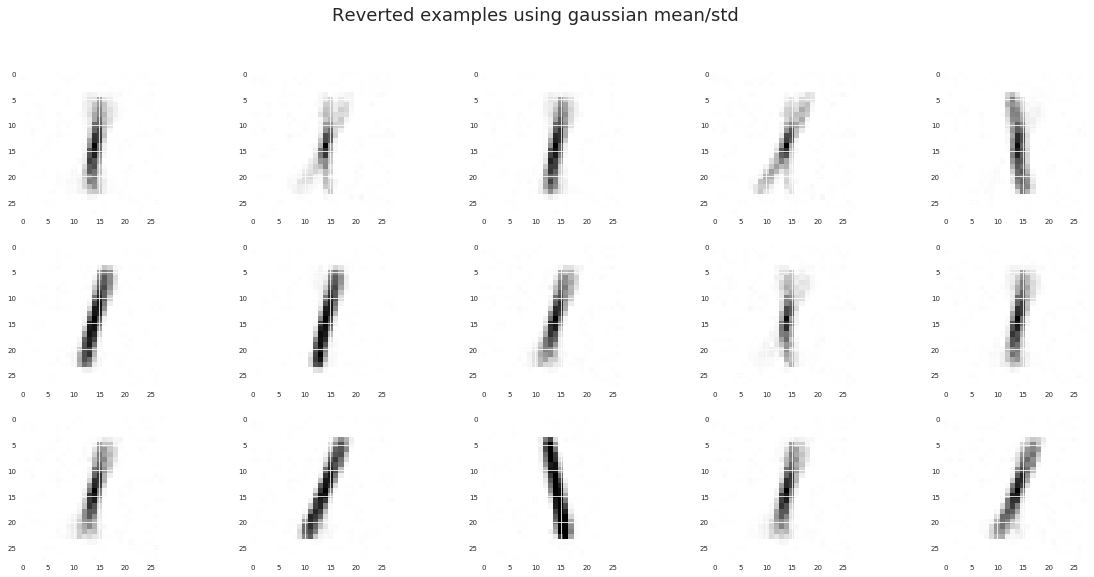

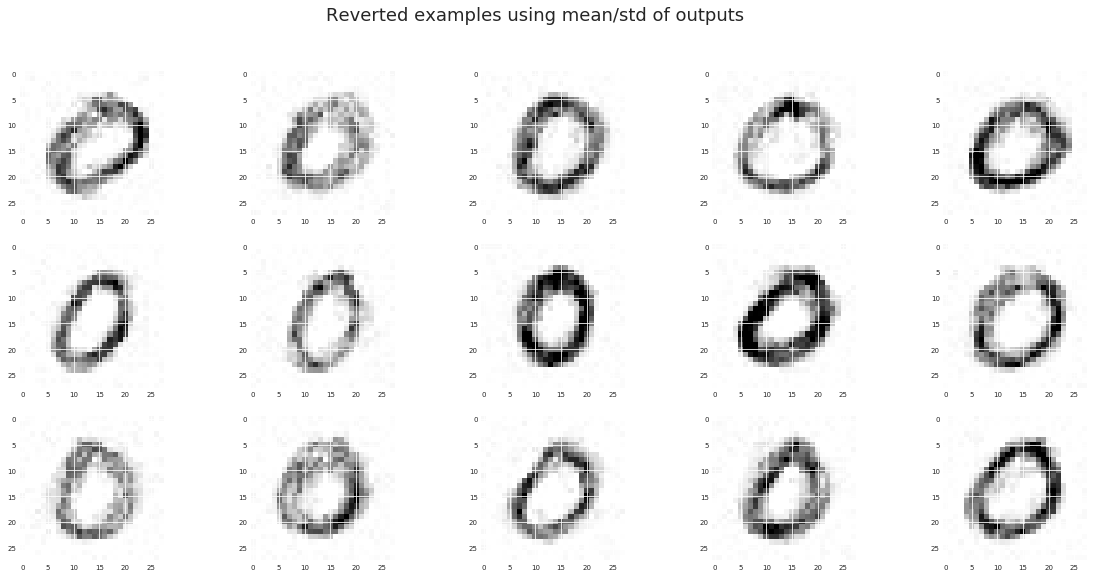

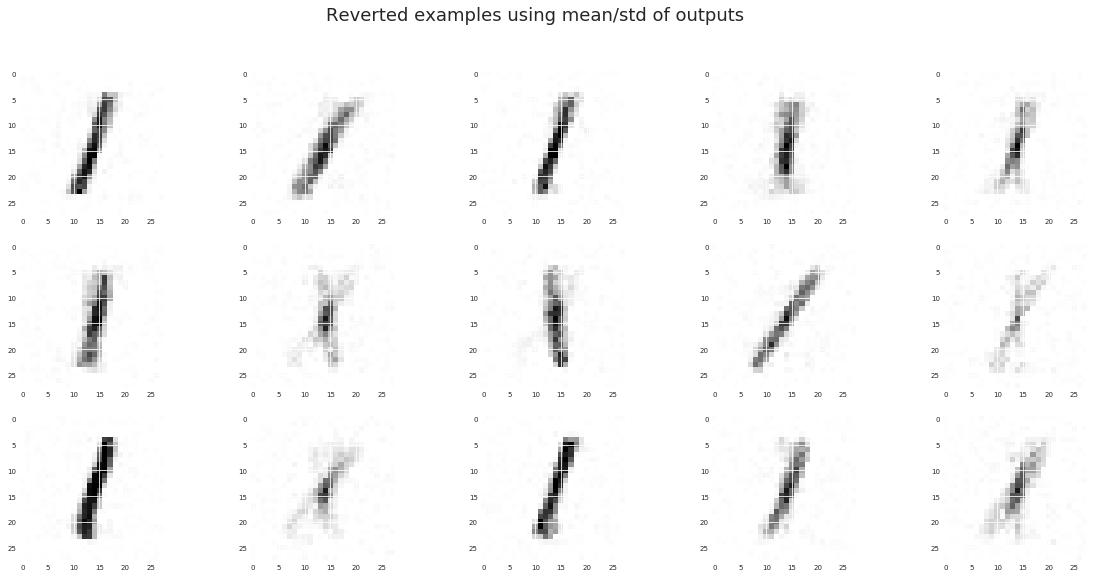

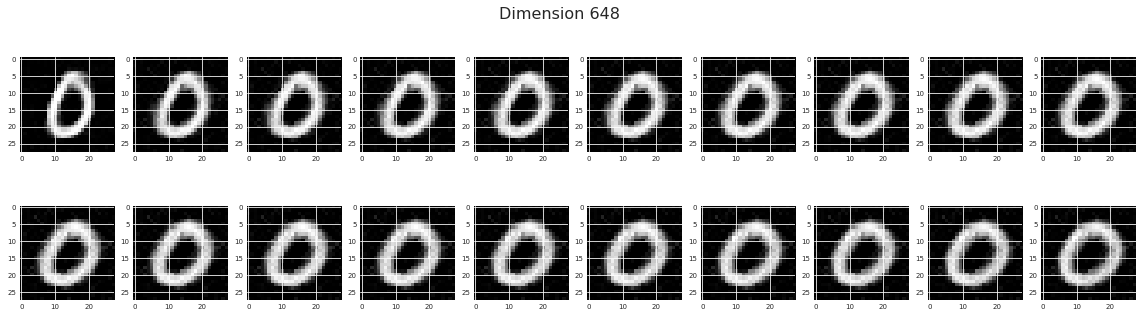

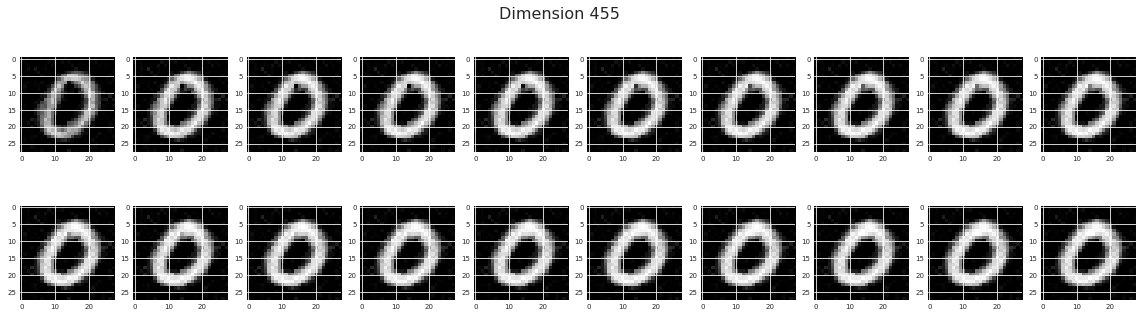

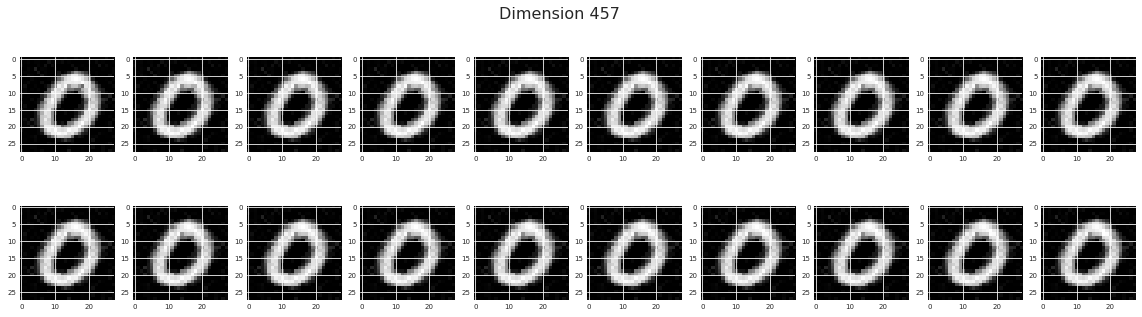

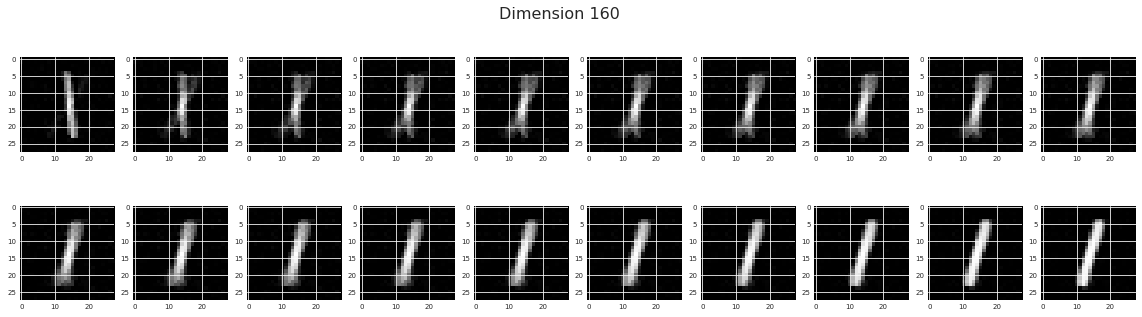

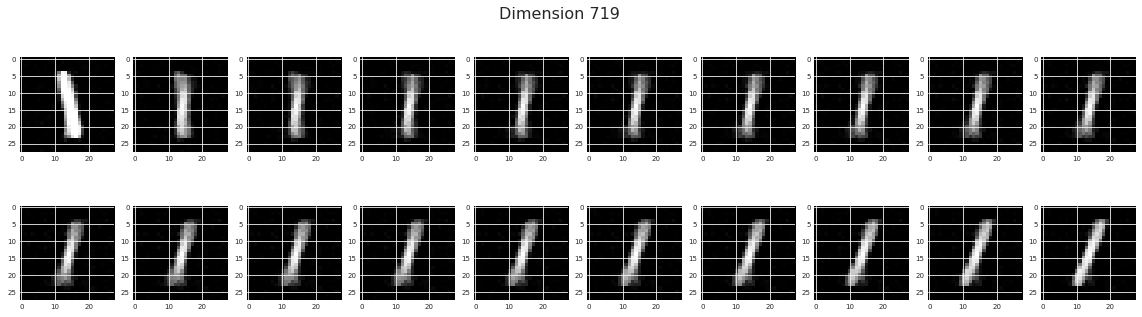

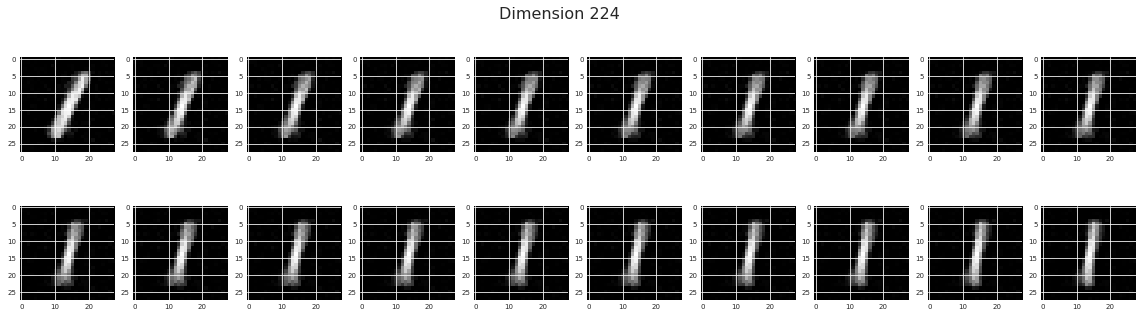

total_loss
310    0.829674

total_loss
320    0.809114

total_loss
330    1.642214

total_loss
340    0.782738

total_loss
350    0.784806

total_loss
360    0.778057

total_loss
370    0.759111

total_loss
380    0.758019

total_loss
390    0.876984

total_loss
400    1.246696

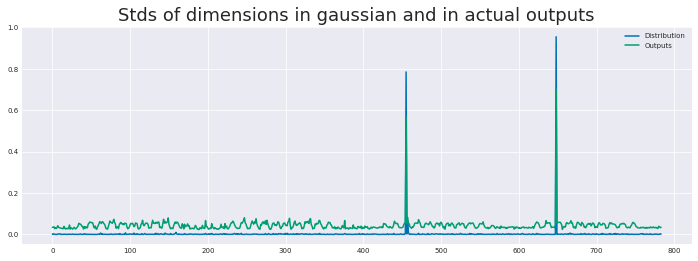

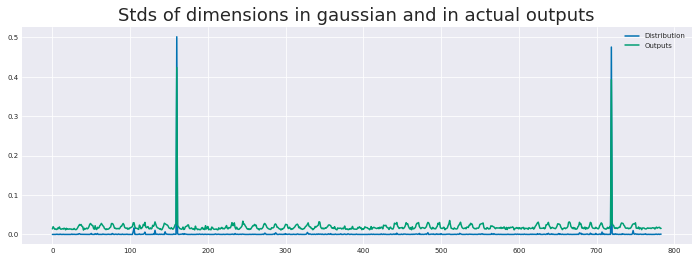

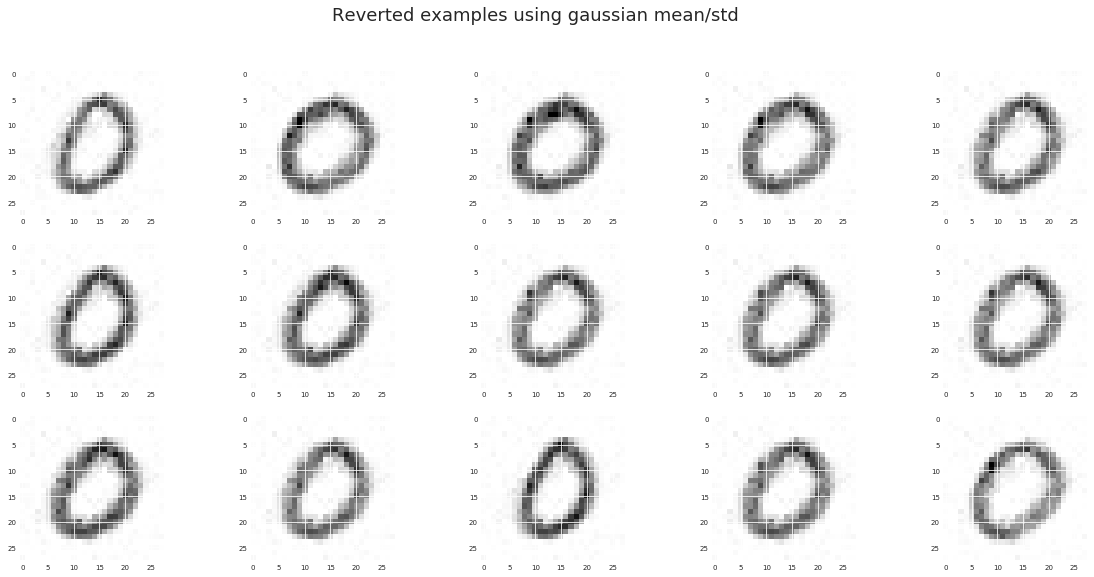

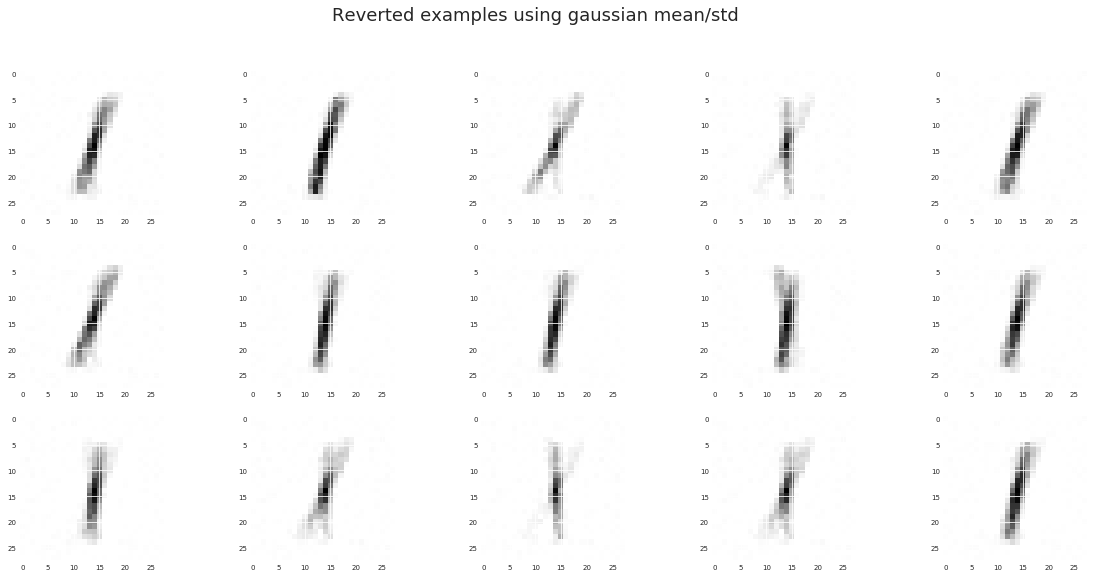

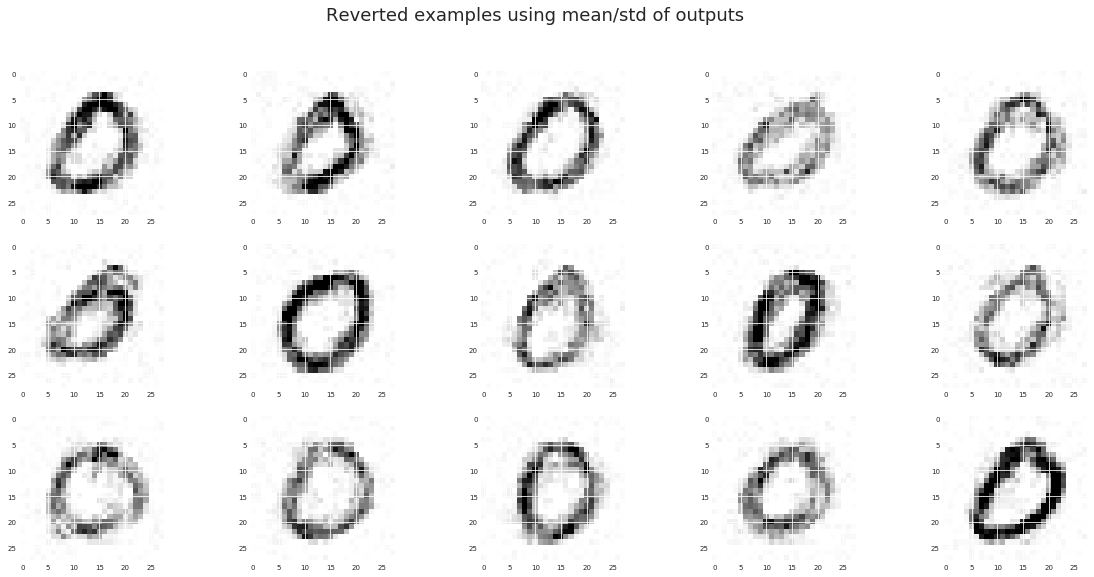

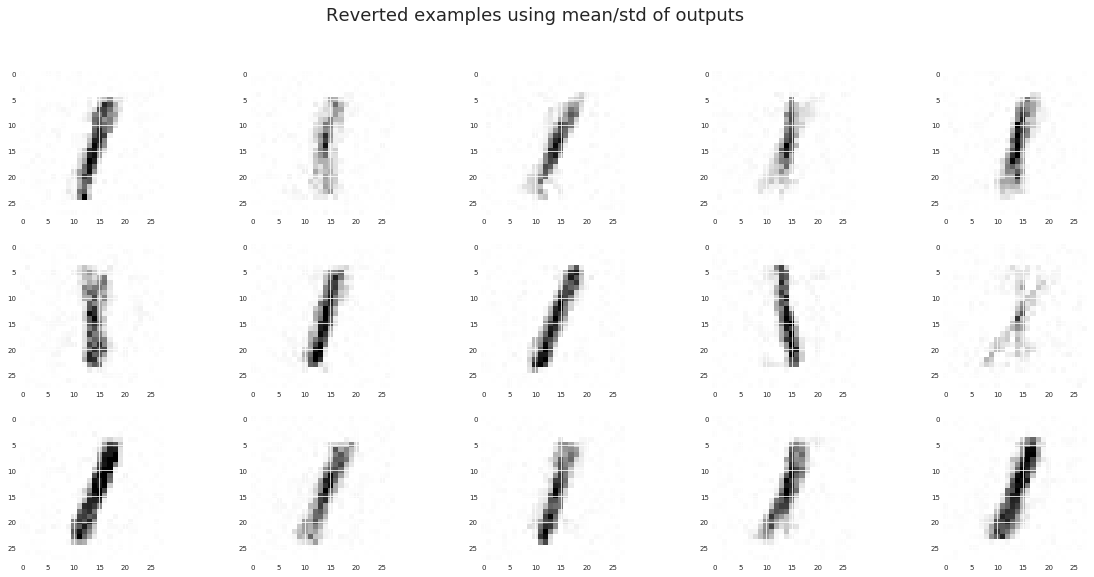

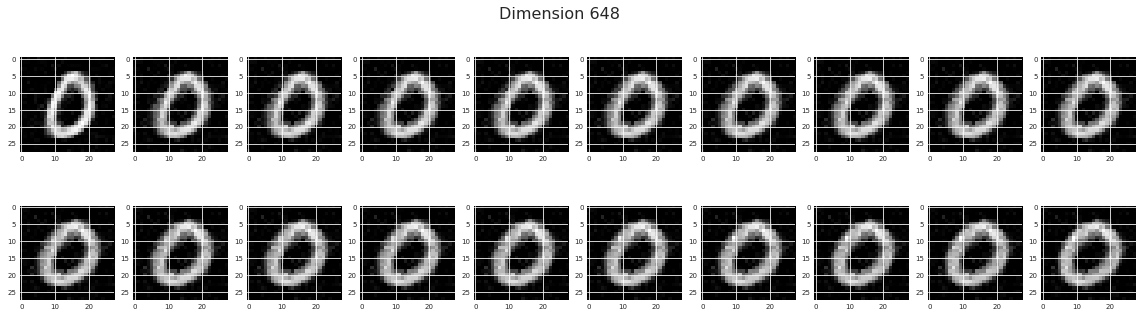

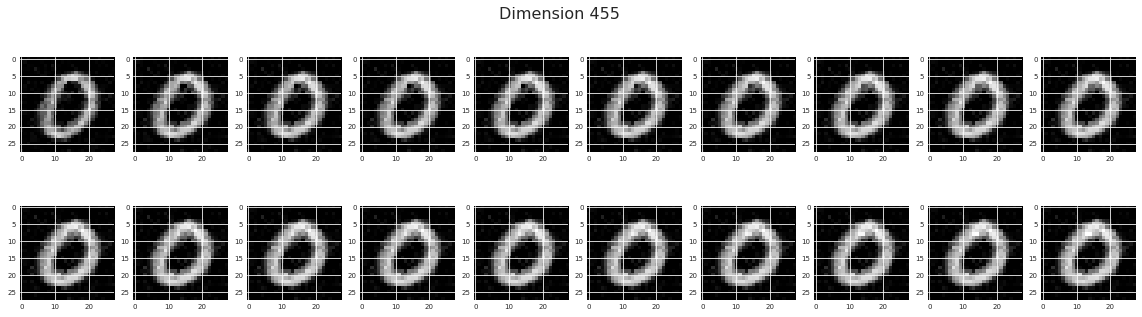

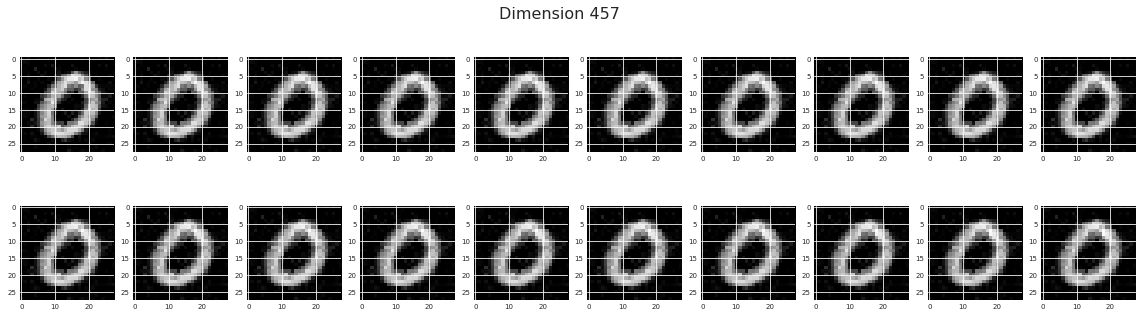

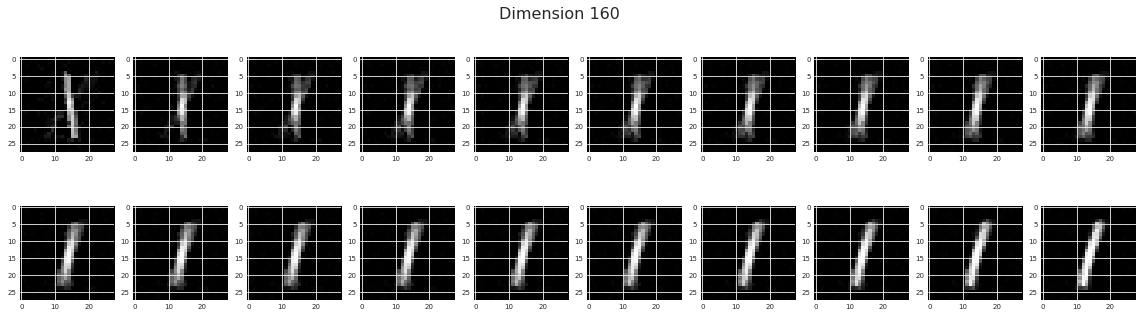

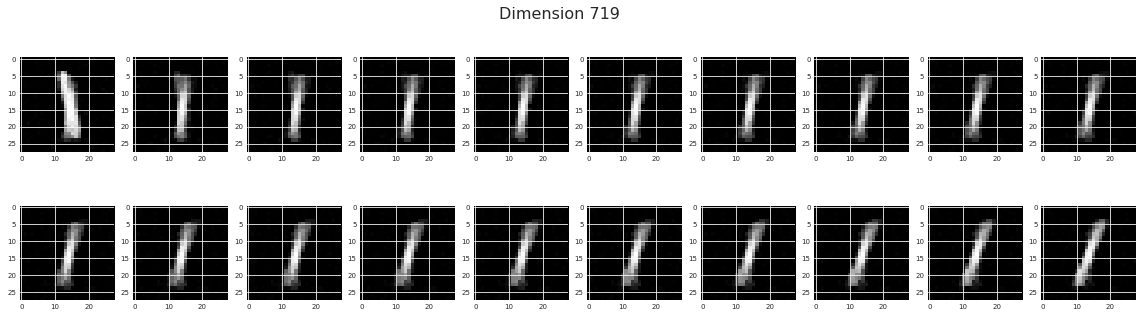

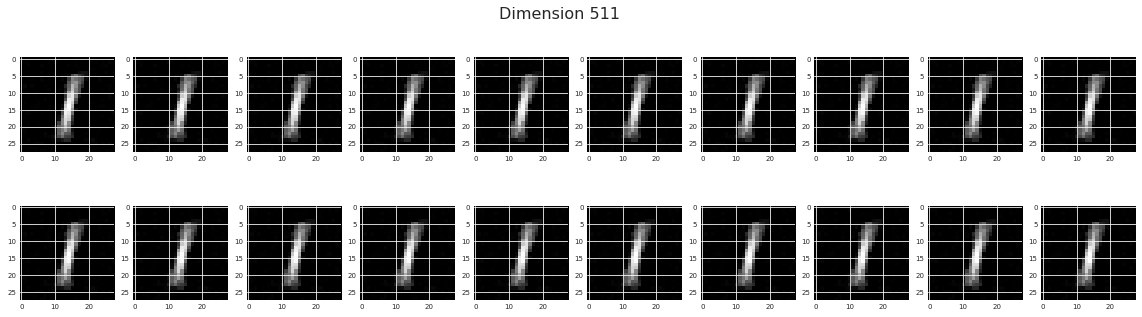

total_loss
410    0.719956

total_loss
420    0.718018

total_loss
430      0.7378

total_loss
440    0.678047

total_loss
450    0.698726

total_loss
460    0.721504

total_loss
470    0.656452

total_loss
480    0.662251

total_loss
490    0.788162

total_loss
500    0.775275

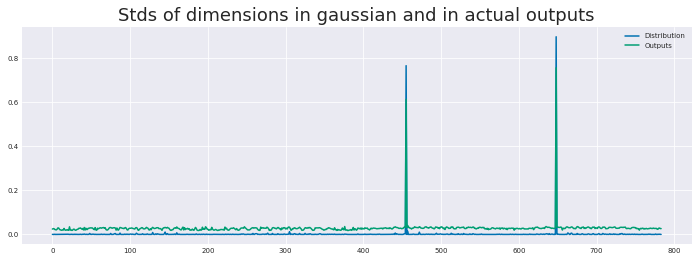

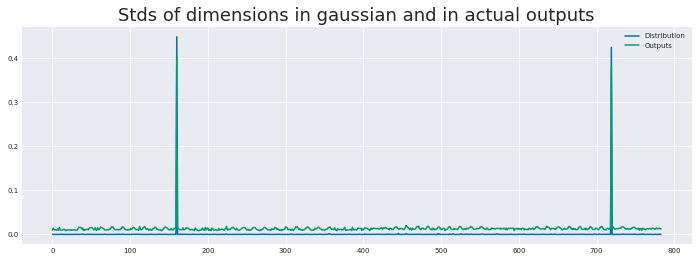

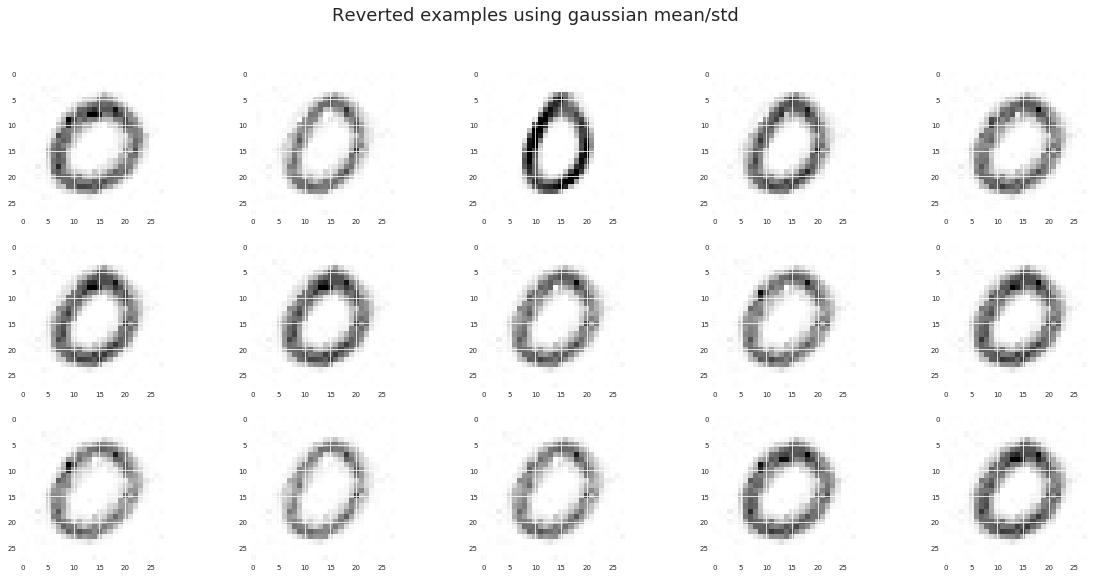

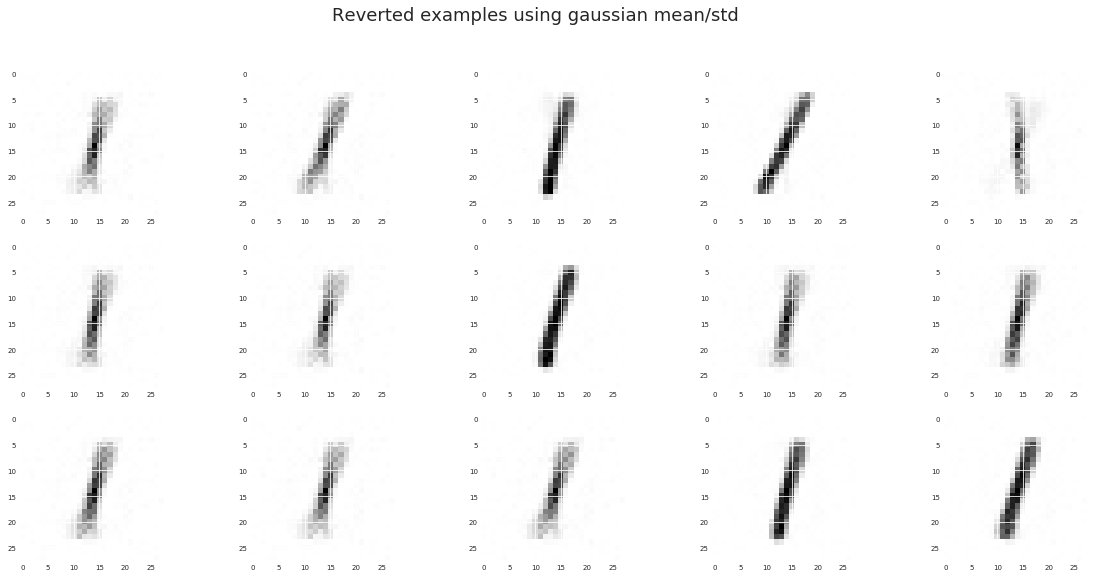

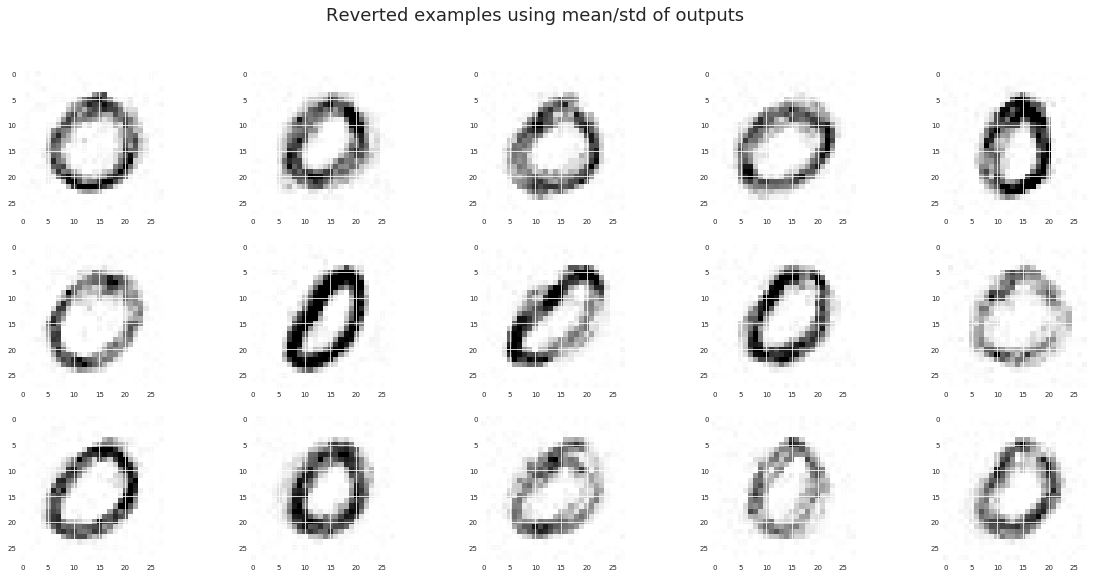

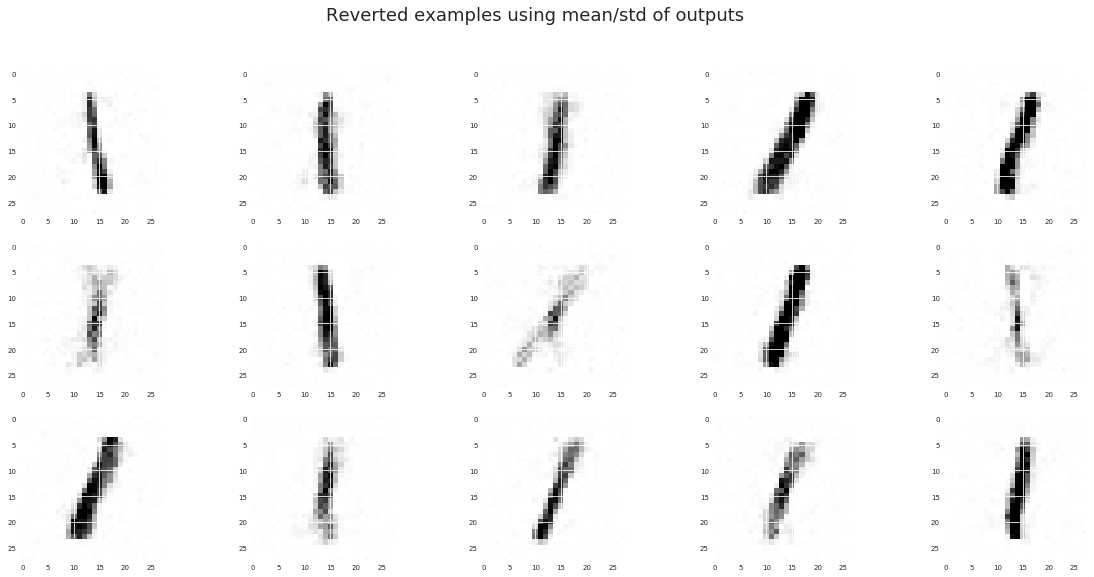

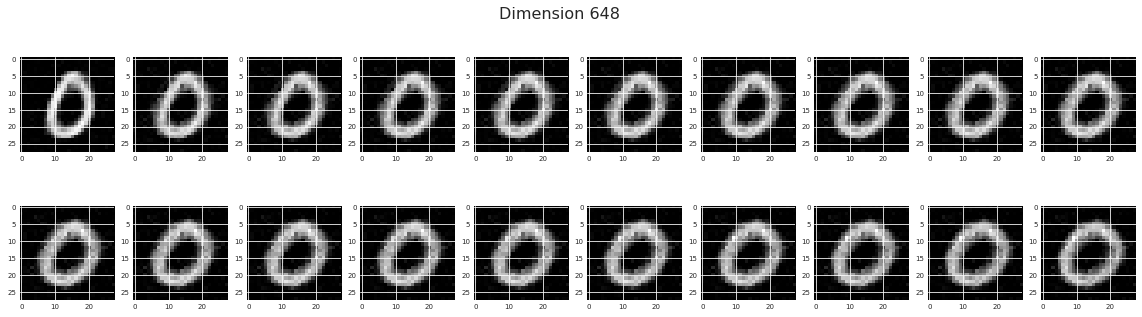

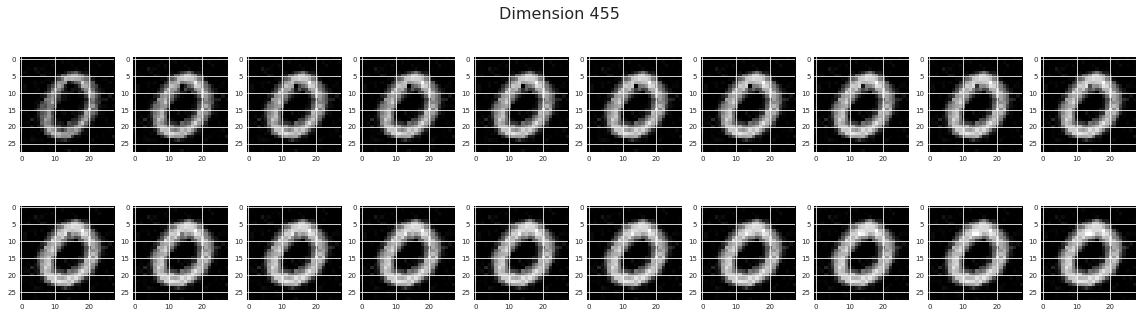

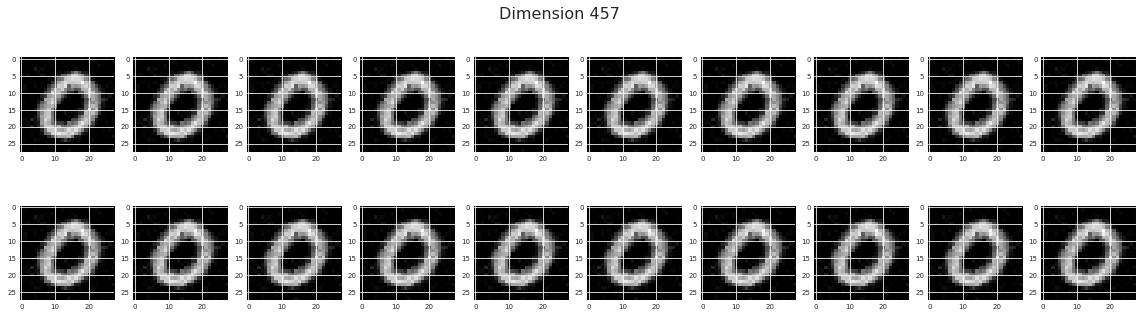

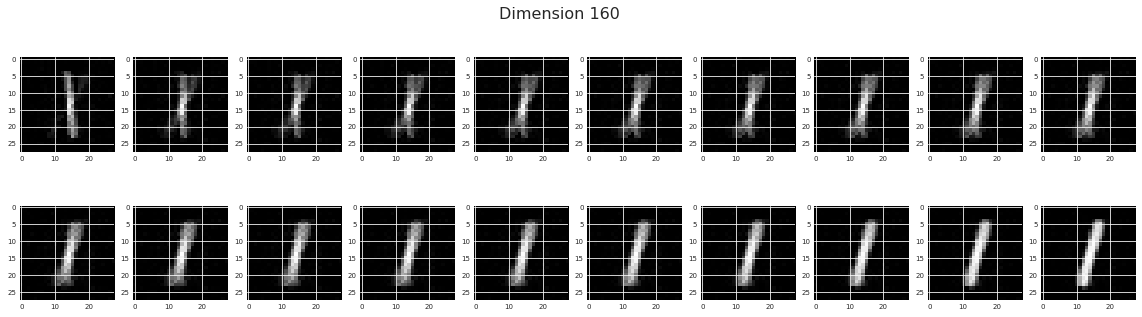

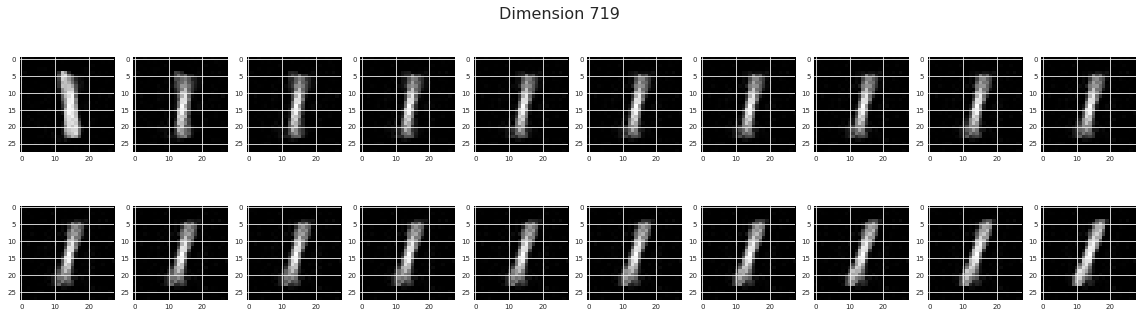

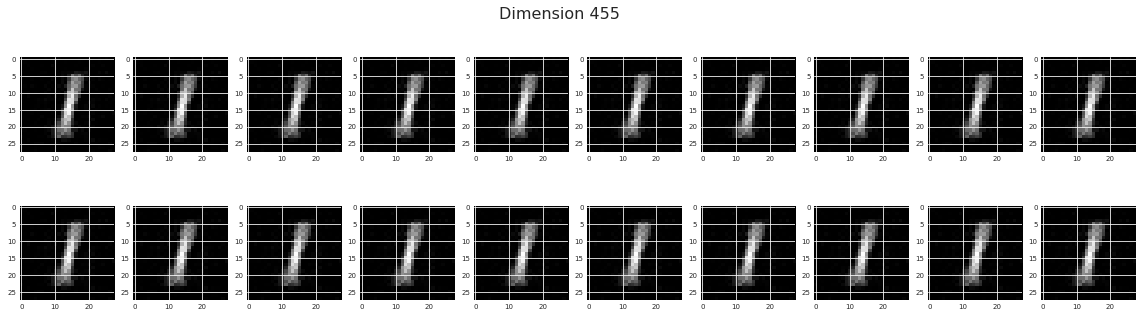

total_loss
510    0.662022

total_loss
520    0.658393

total_loss
530    0.648361

total_loss
540     0.65132

total_loss
550    0.679071

total_loss
560     0.66889

total_loss
570    0.603109

total_loss
580    0.623682

total_loss
590    5.537898

total_loss
600    4.652774

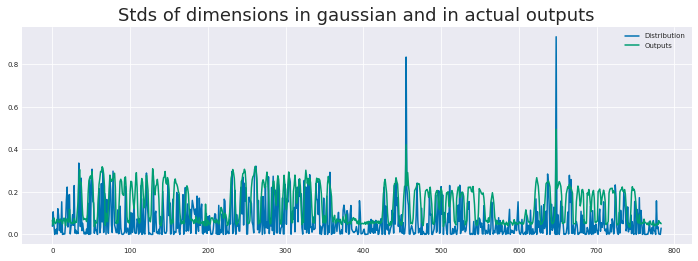

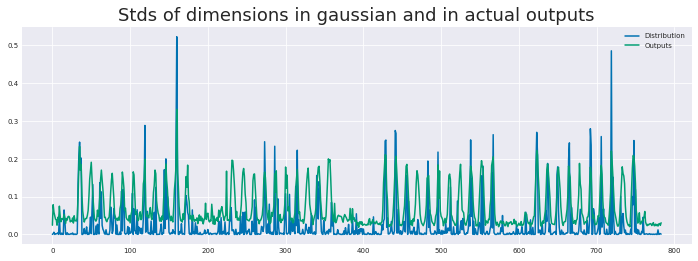

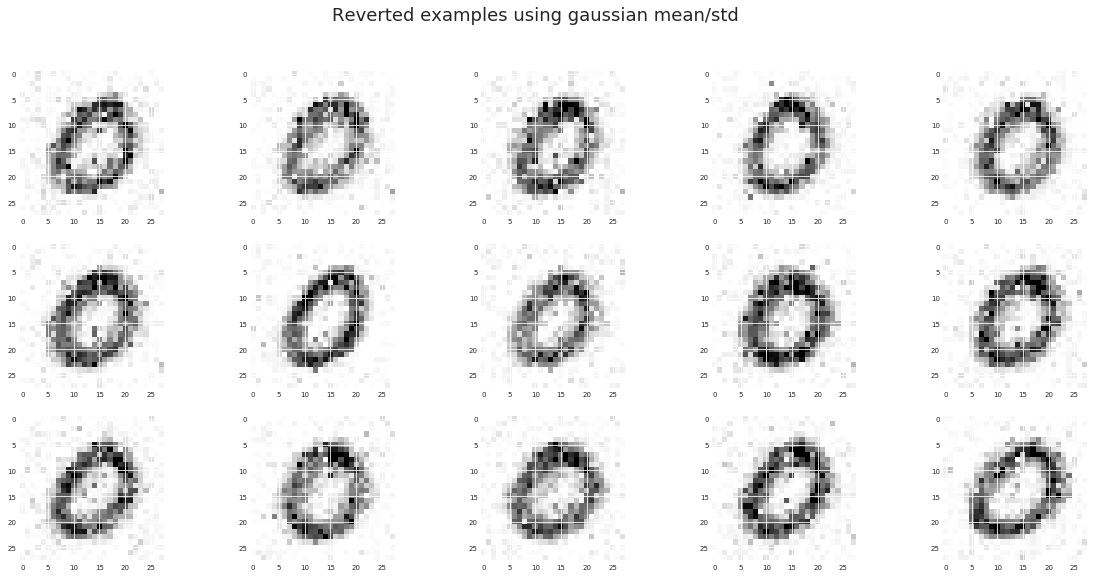

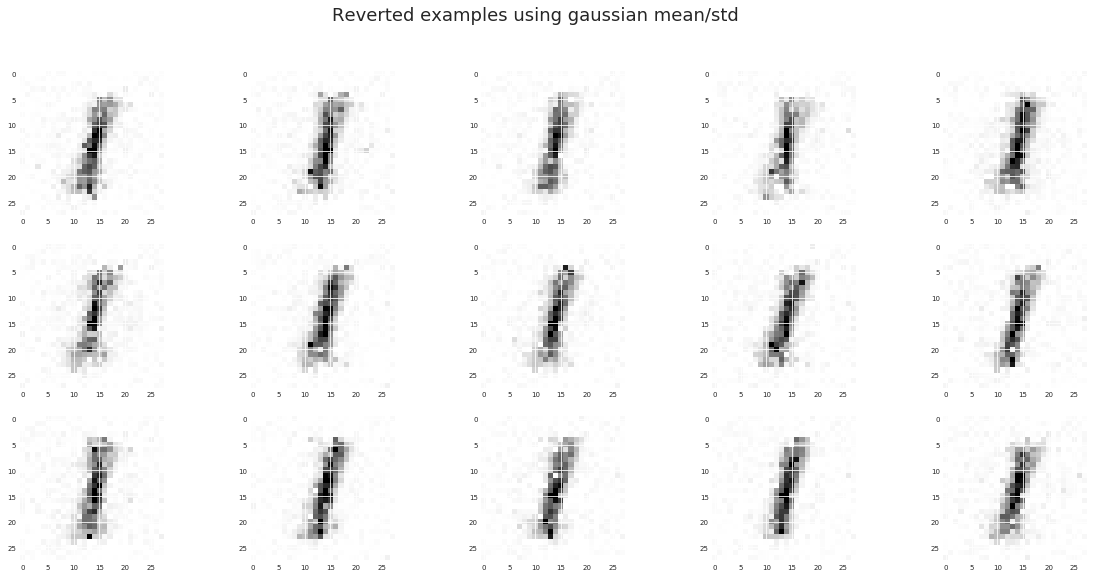

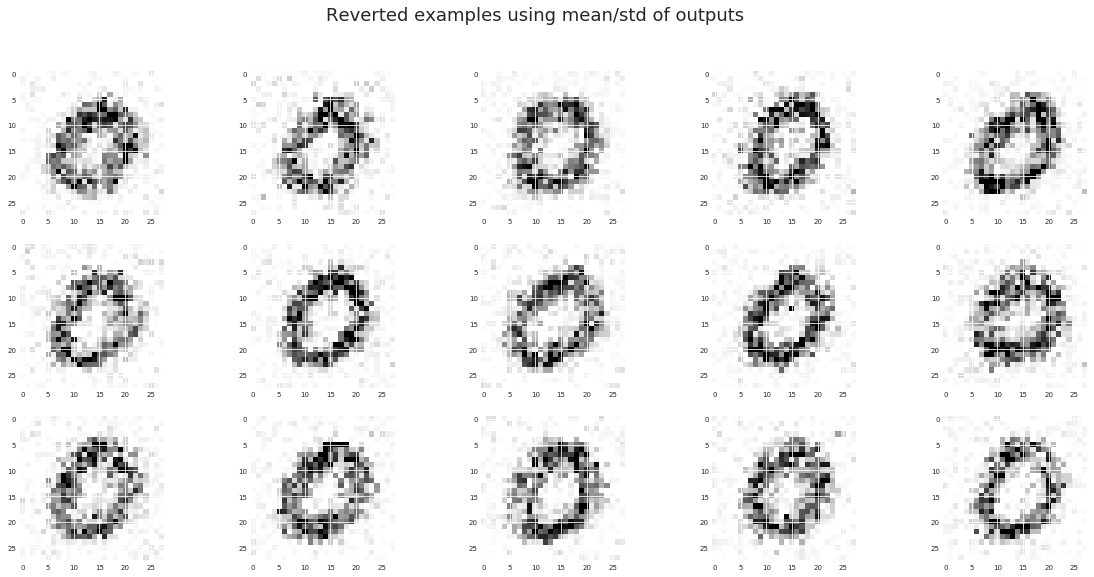

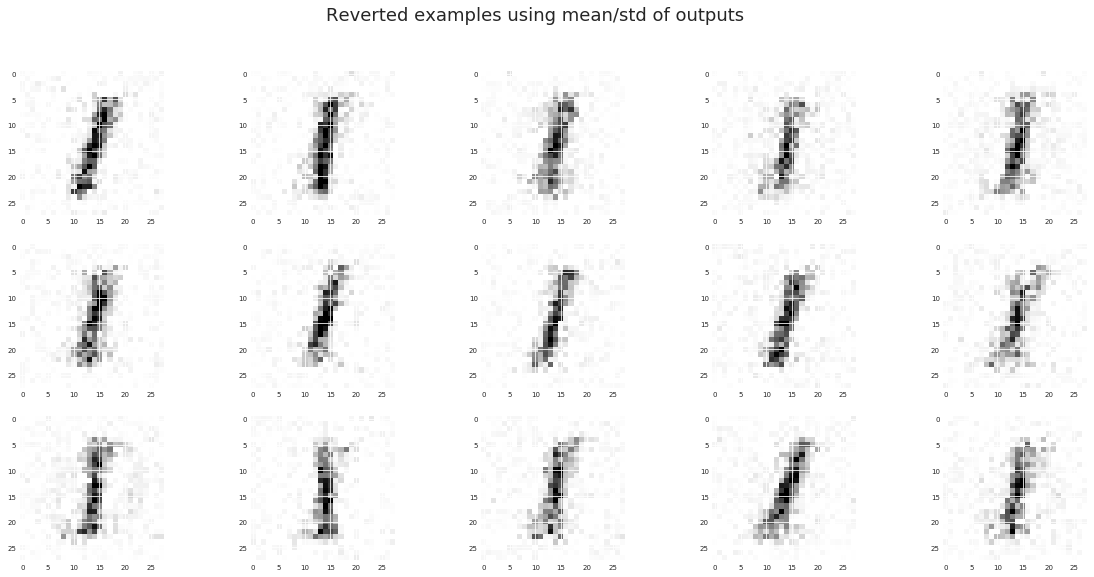

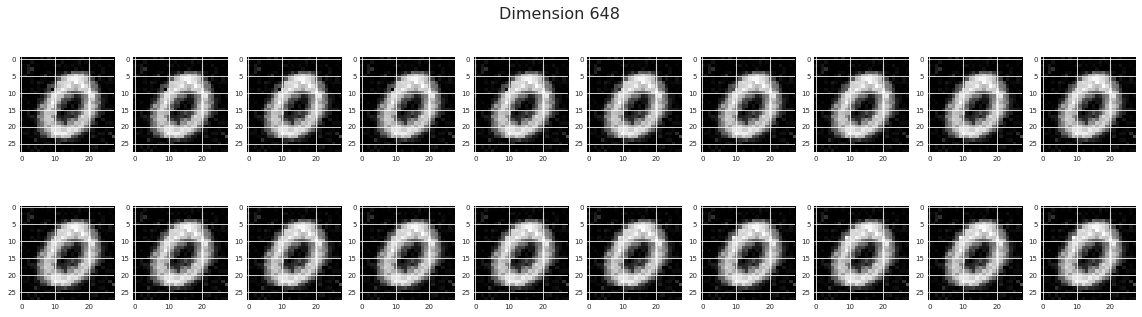

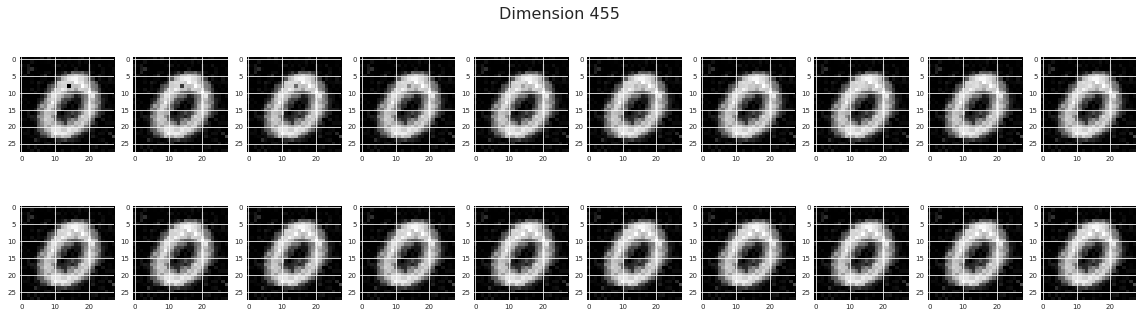

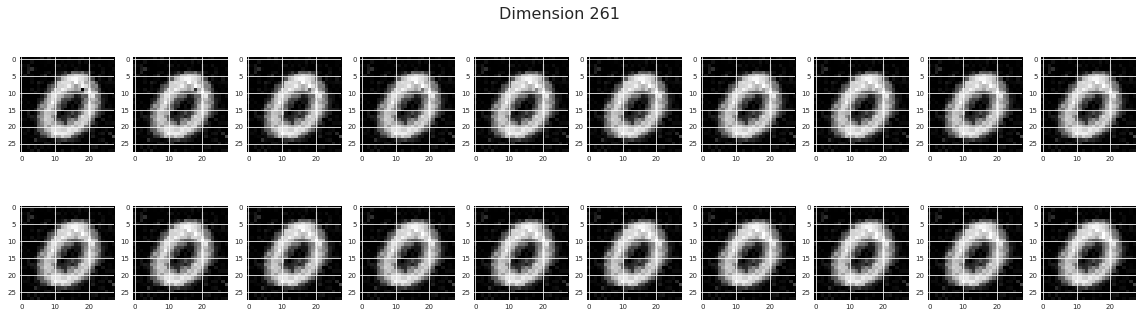

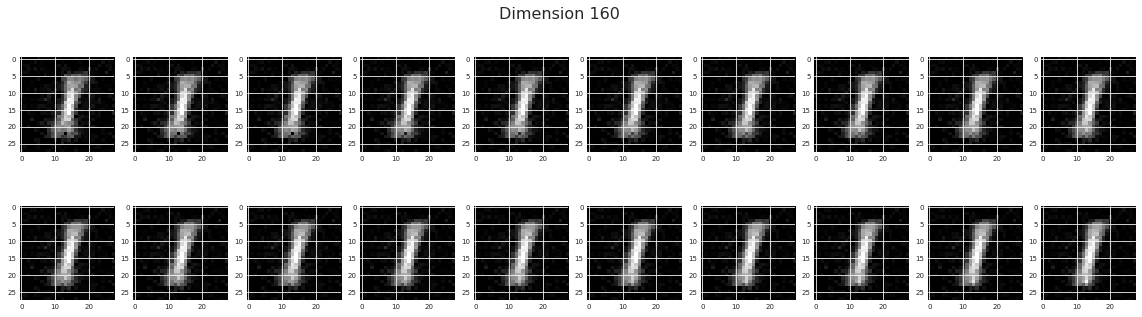

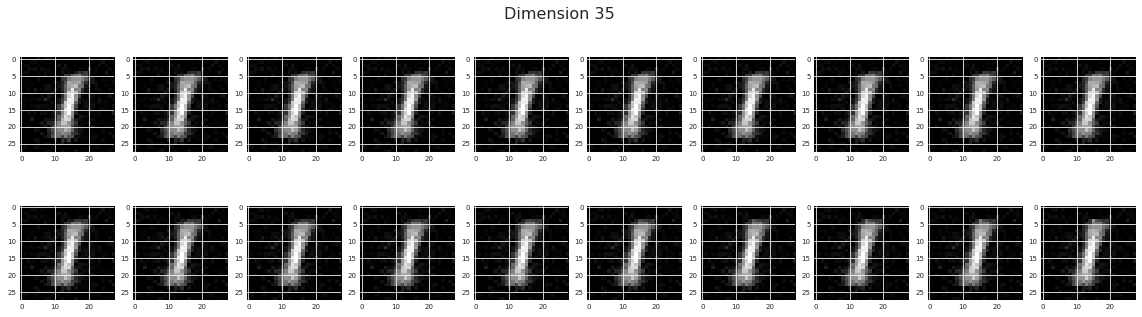

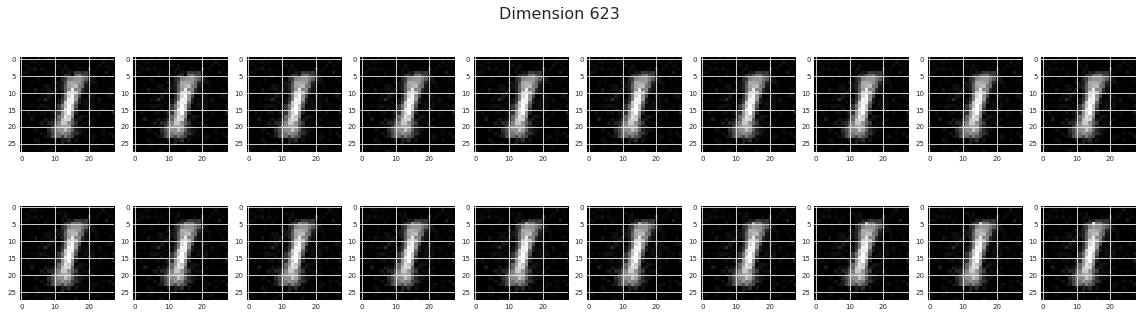

total_loss
610    3.296073

total_loss
620     2.84348

total_loss
630    2.574367

total_loss
640    2.412879

total_loss
650    2.270722

total_loss
660    2.182426

total_loss
670    2.076715

total_loss
680    2.004552

total_loss
690    2.022042

total_loss
700     1.91113

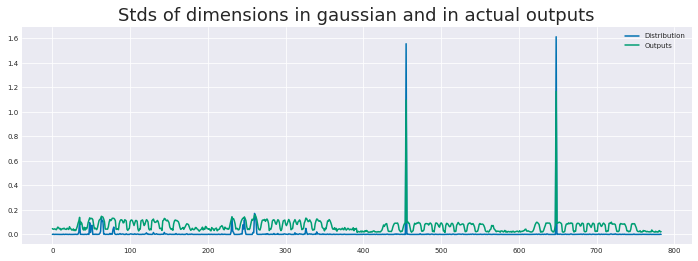

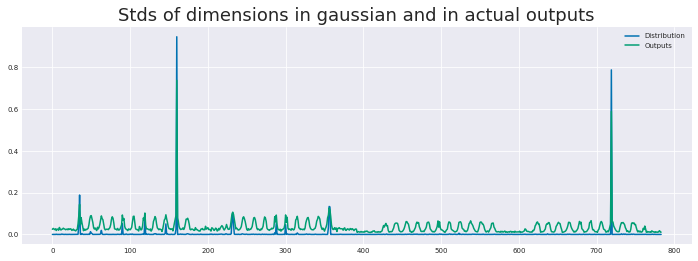

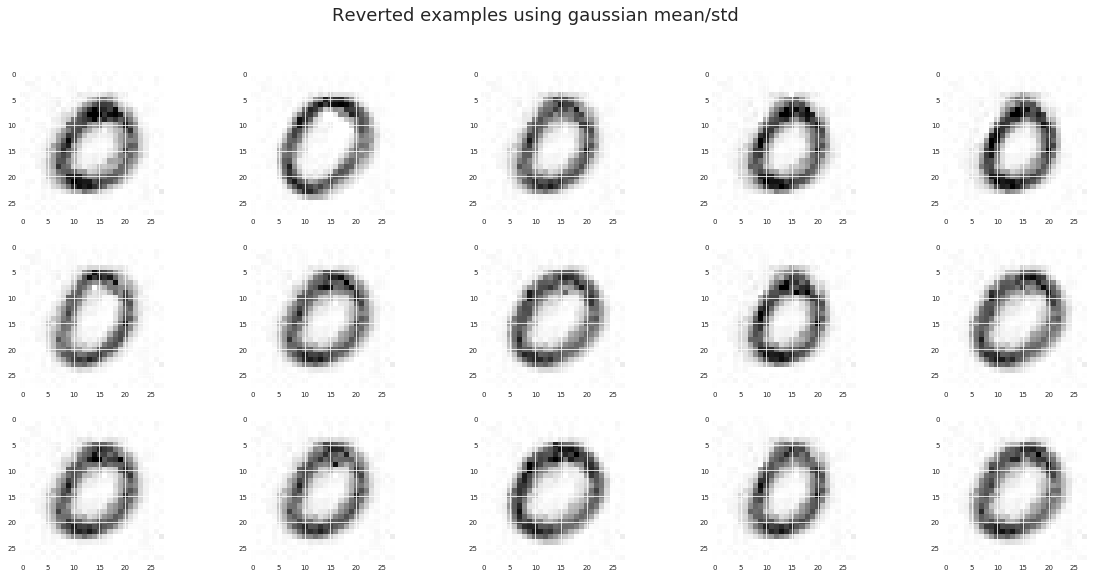

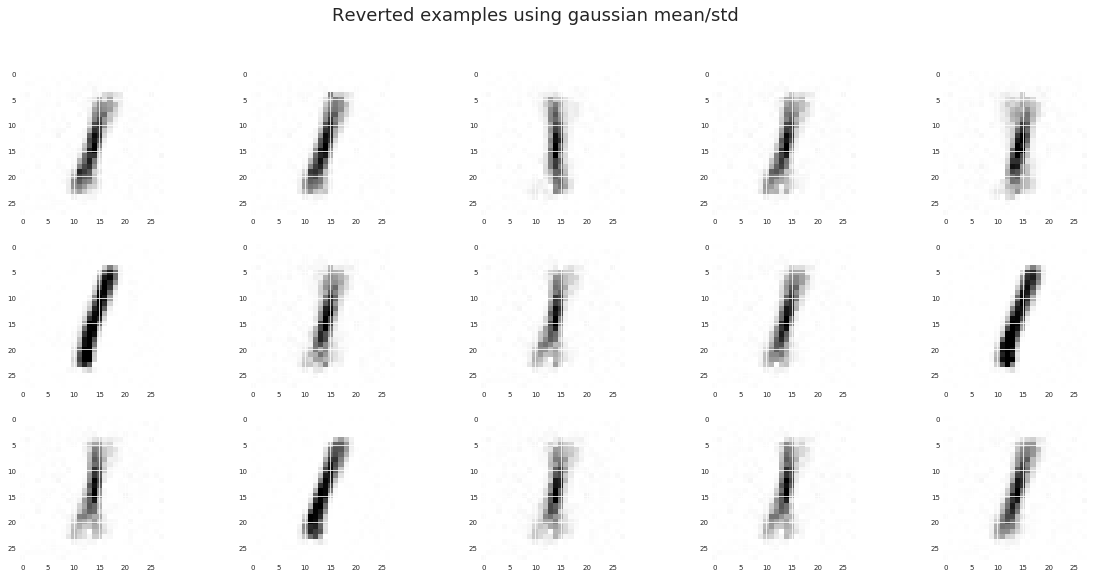

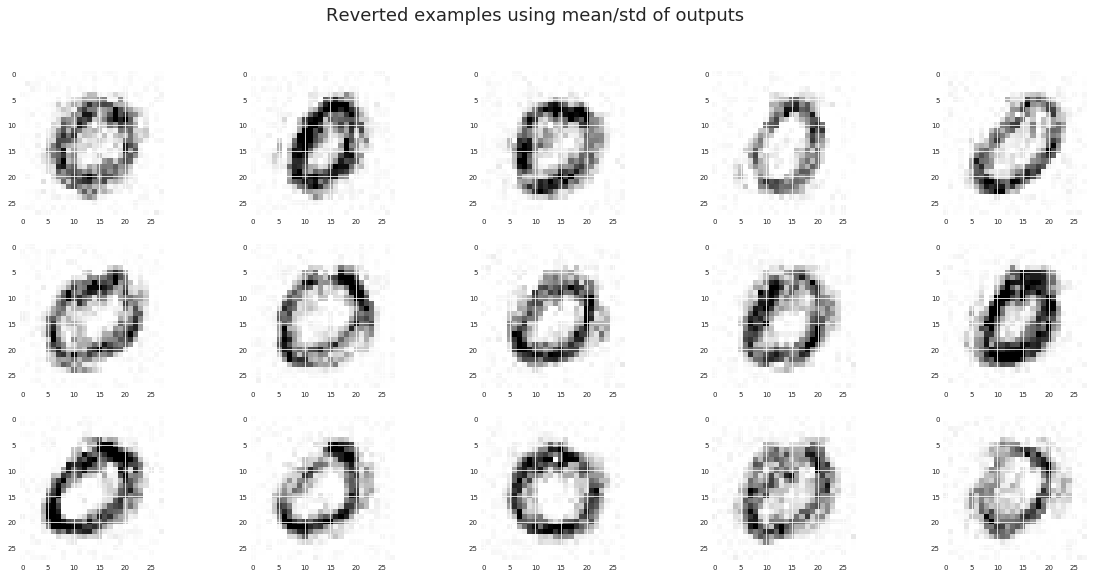

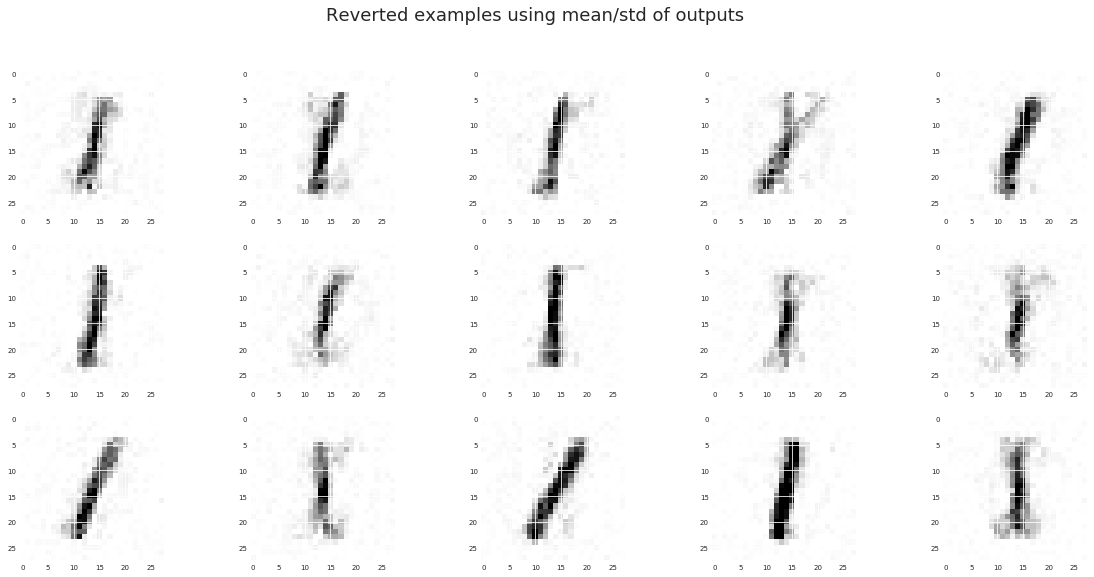

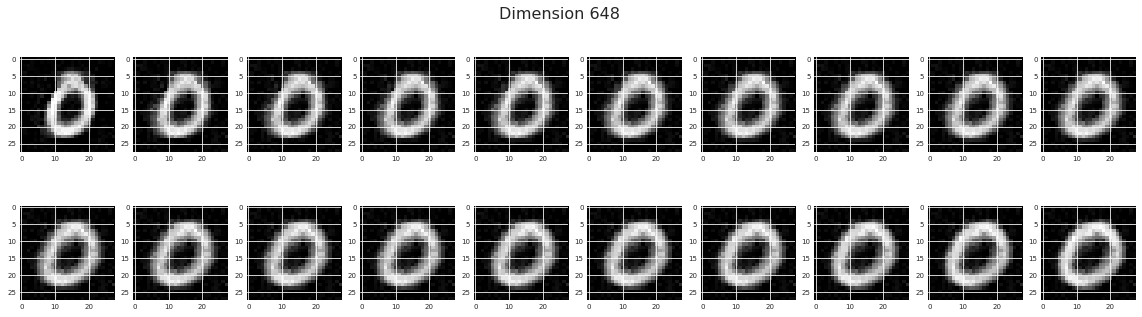

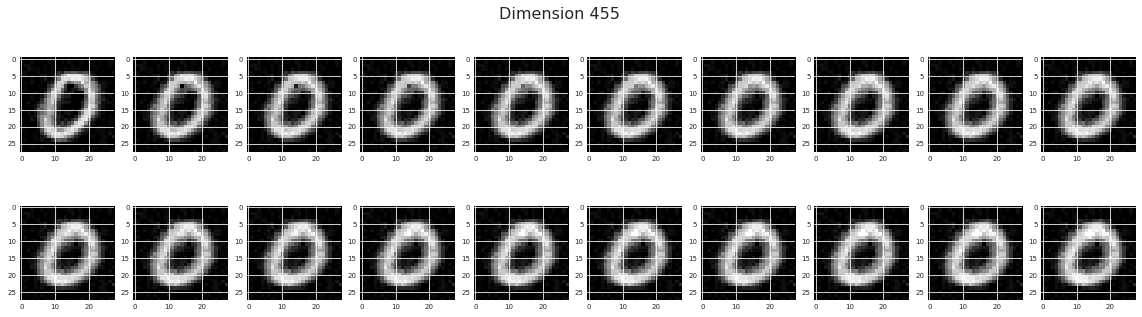

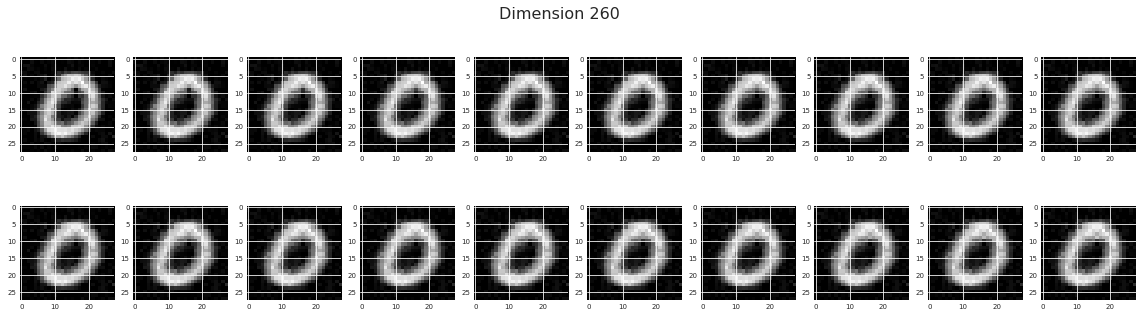

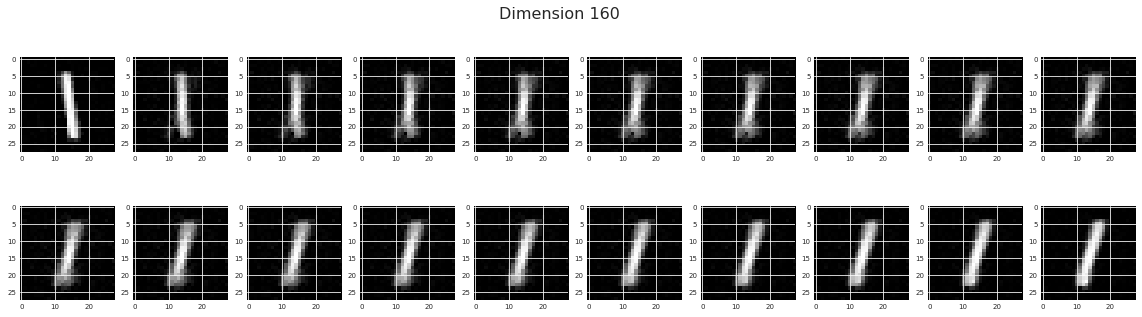

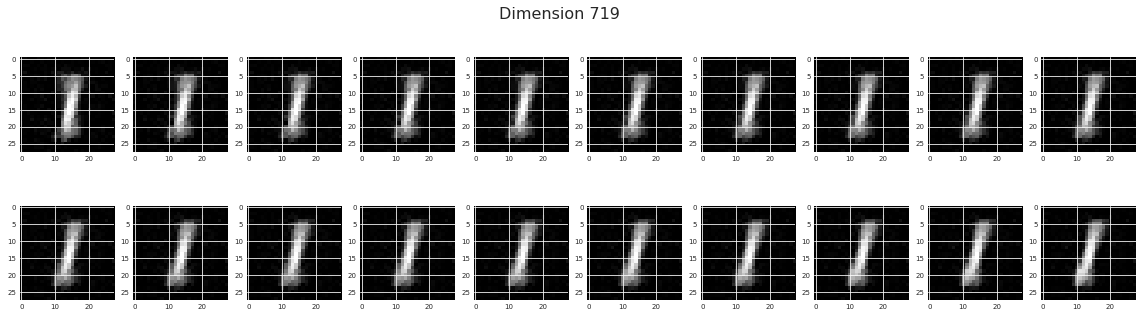

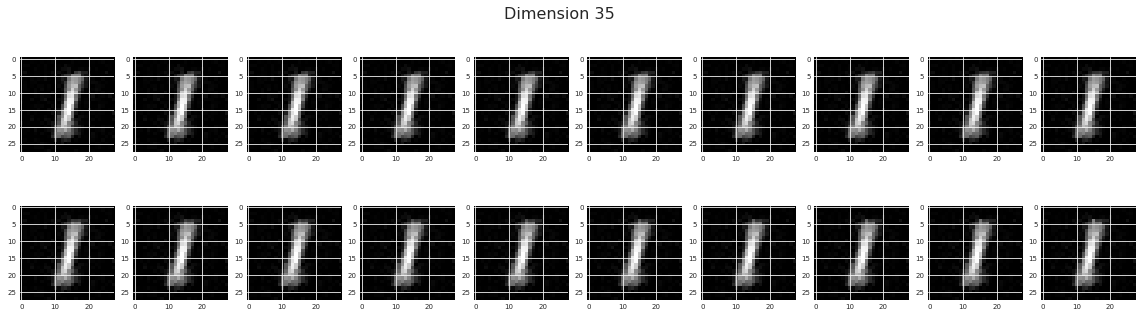

total_loss
710    1.904397

total_loss
720    1.828703

total_loss
730    1.806971

total_loss
740    1.806368

total_loss
750    1.735201

total_loss
760    1.738366

total_loss
770    1.711761

total_loss
780    1.683467

total_loss
790    1.643702

total_loss
800    1.615054

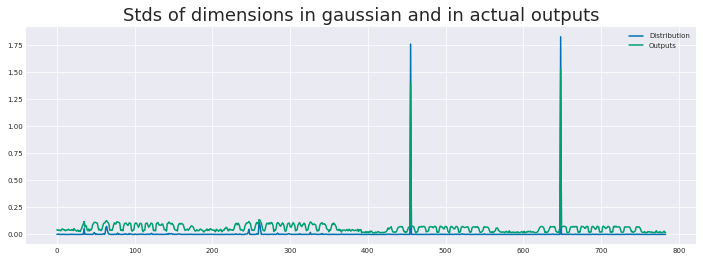

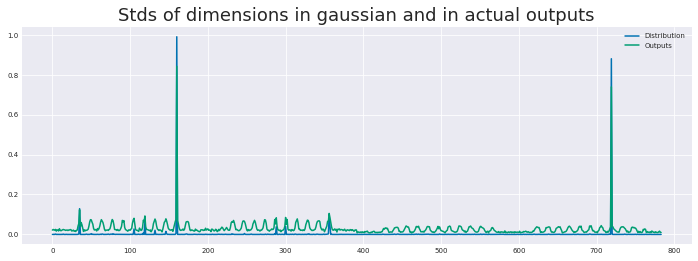

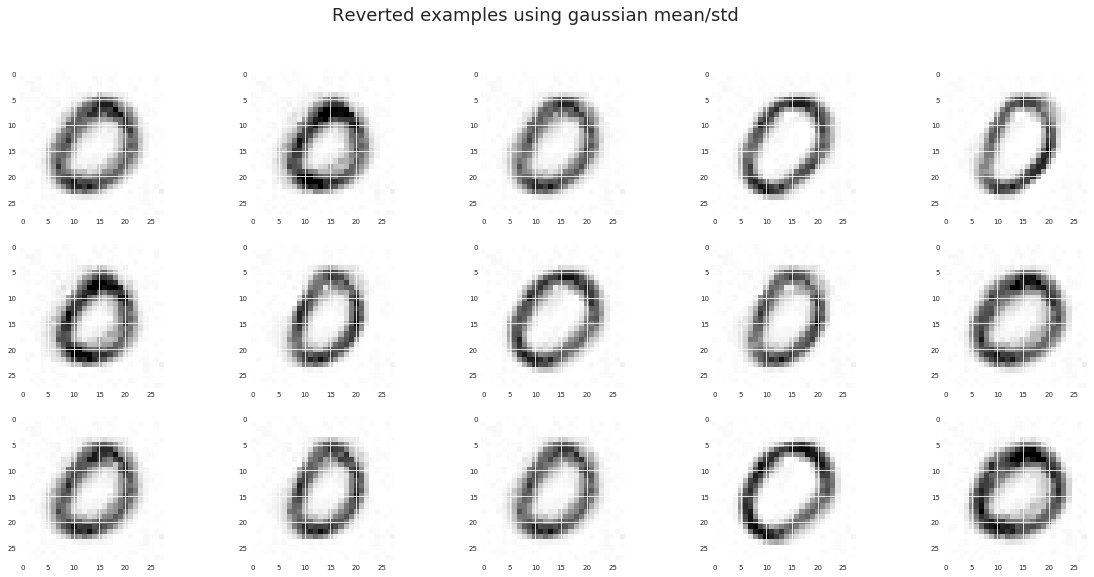

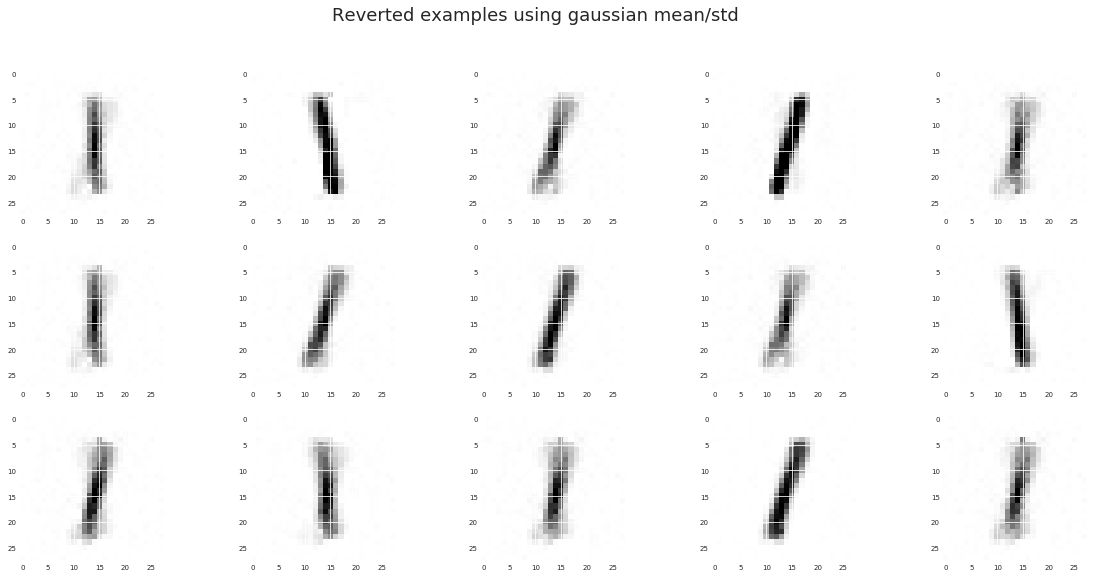

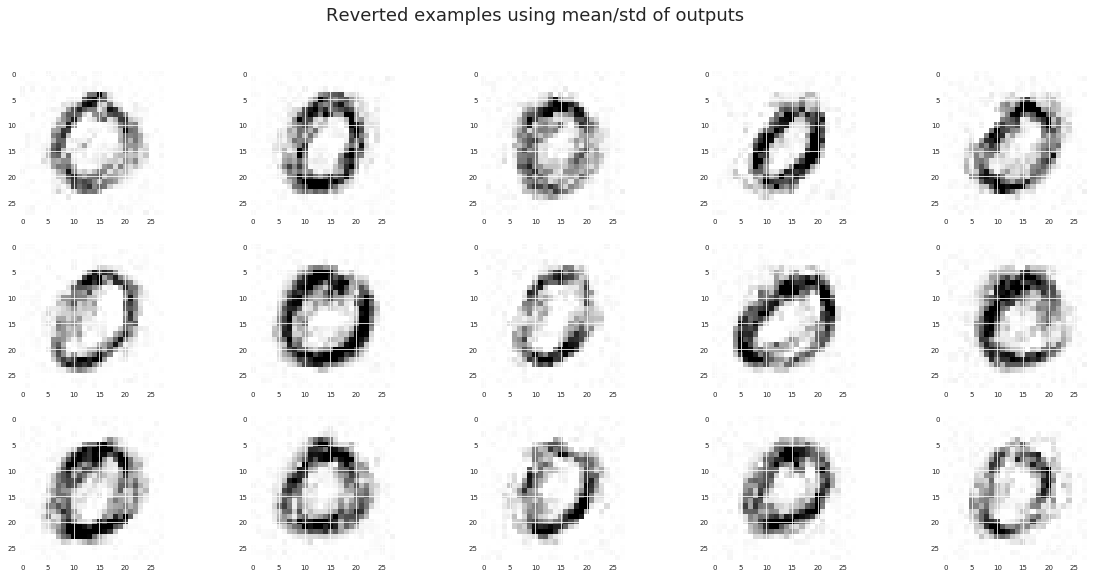

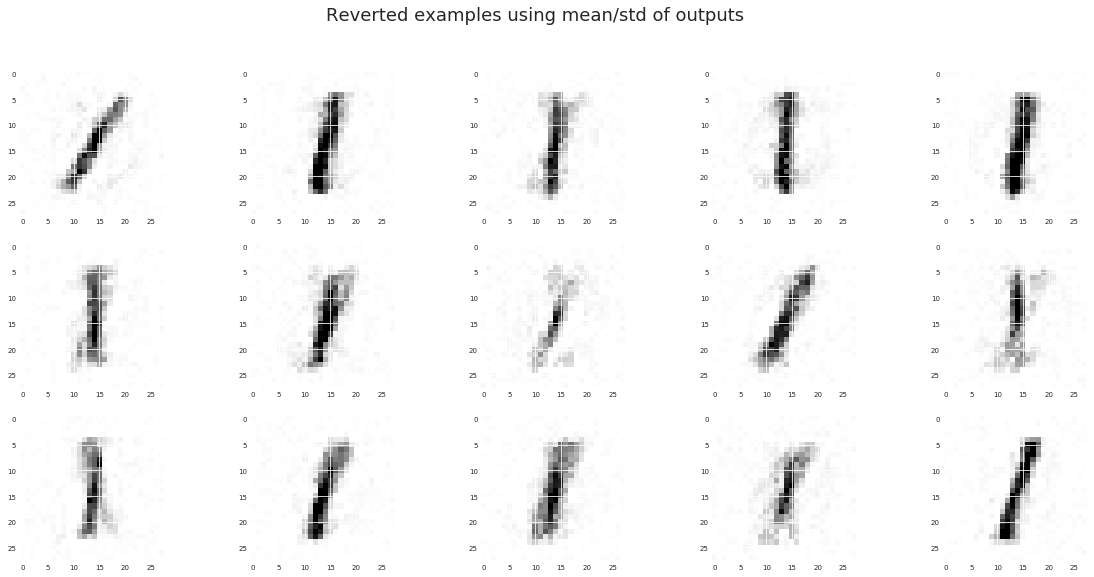

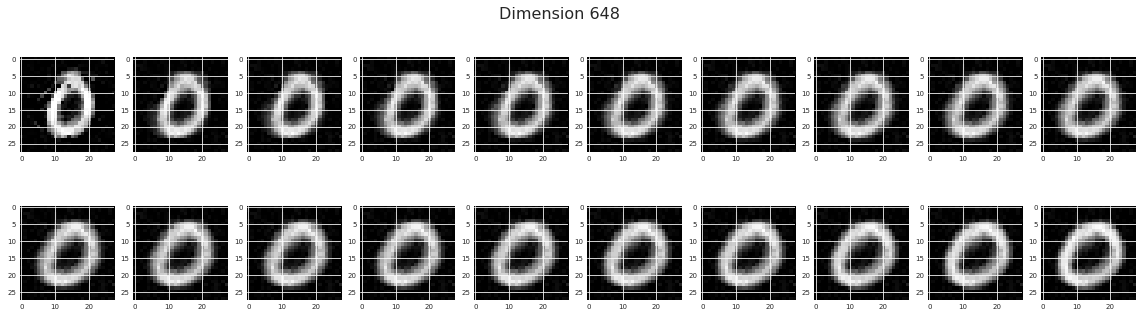

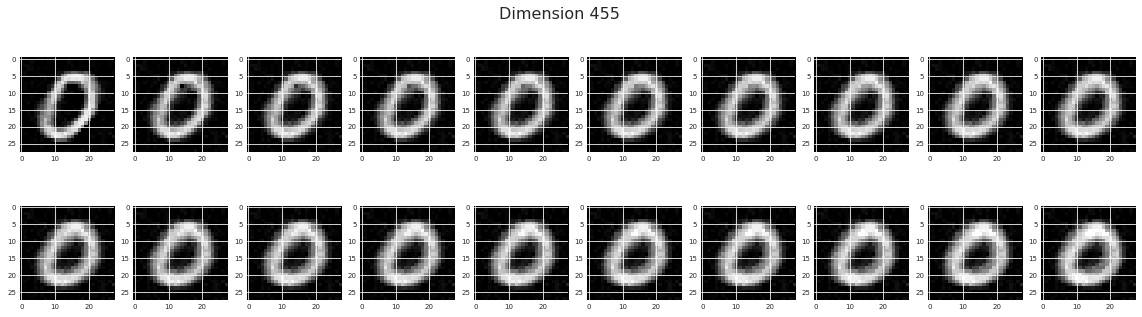

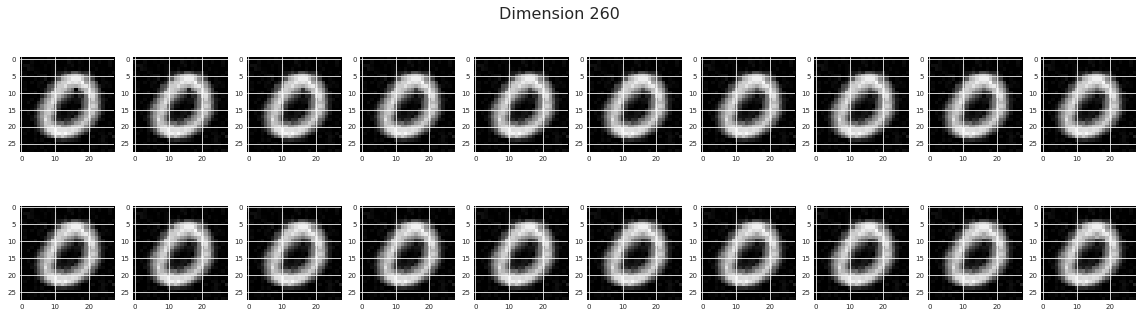

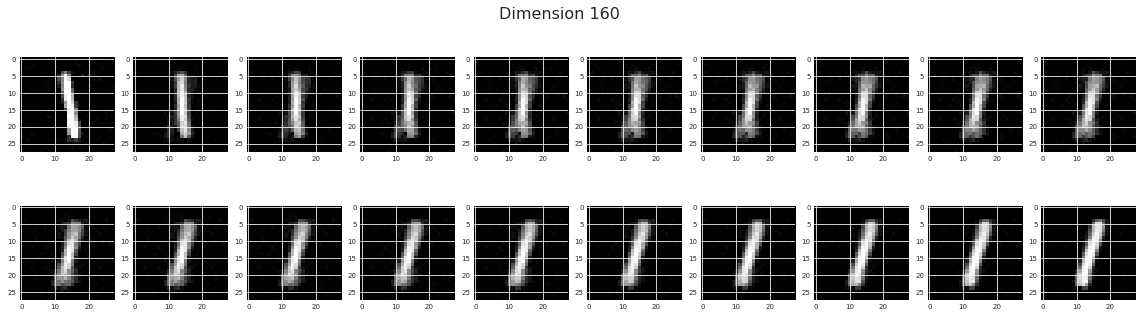

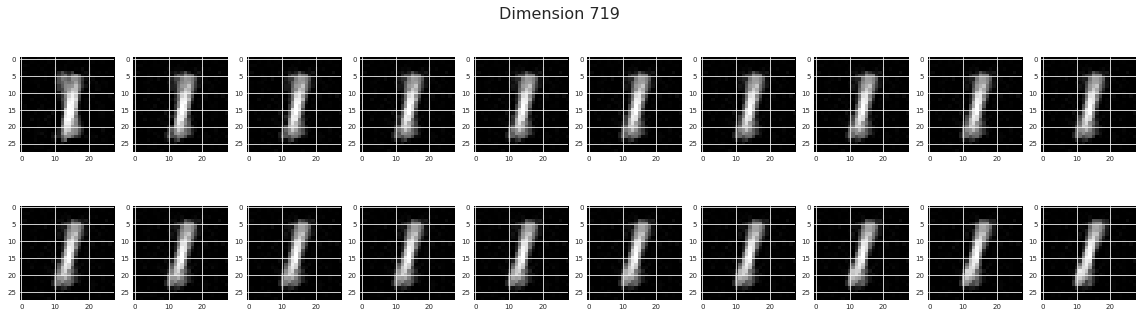

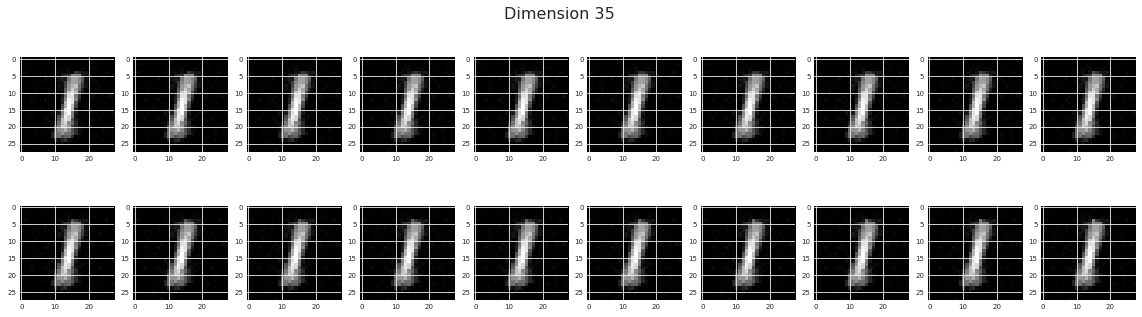

total_loss
810    1.695625

total_loss
820    1.576863

total_loss
830    1.599606

total_loss
840    1.577666

total_loss
850    1.537976

total_loss
860    1.519946

total_loss
870    1.525893

total_loss
880    1.456931

total_loss
890    1.468216

total_loss
900    1.444764

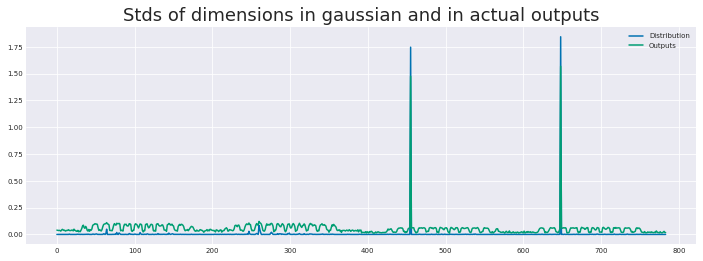

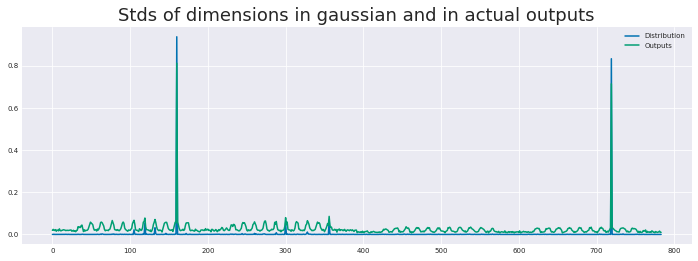

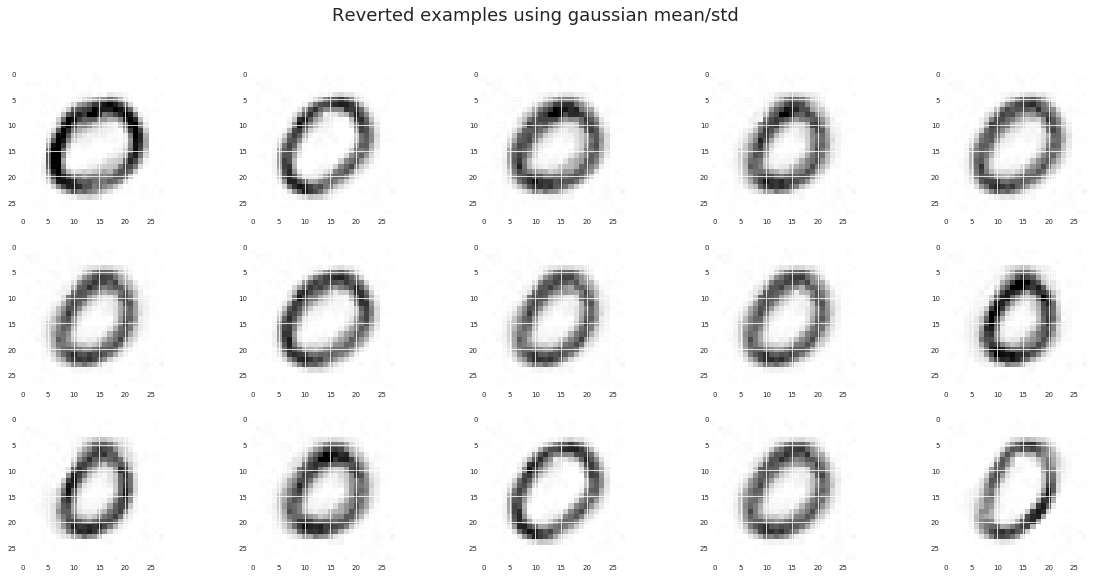

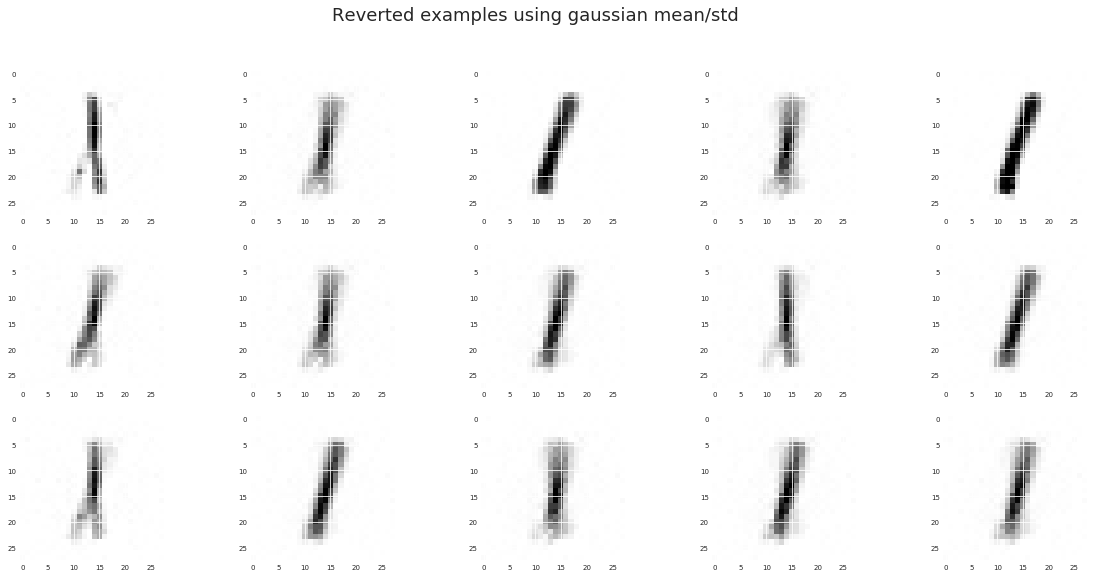

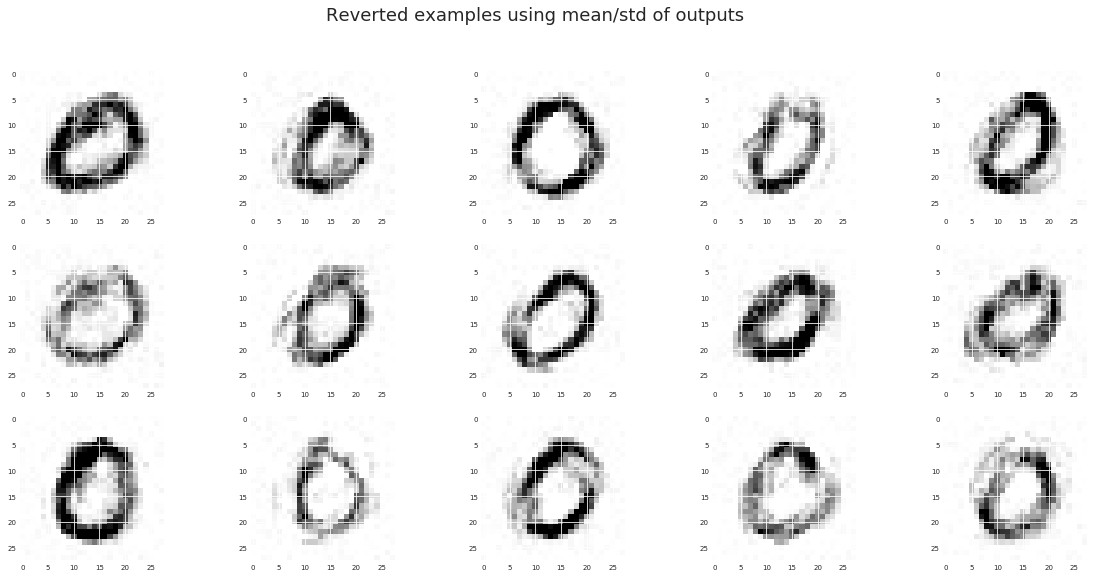

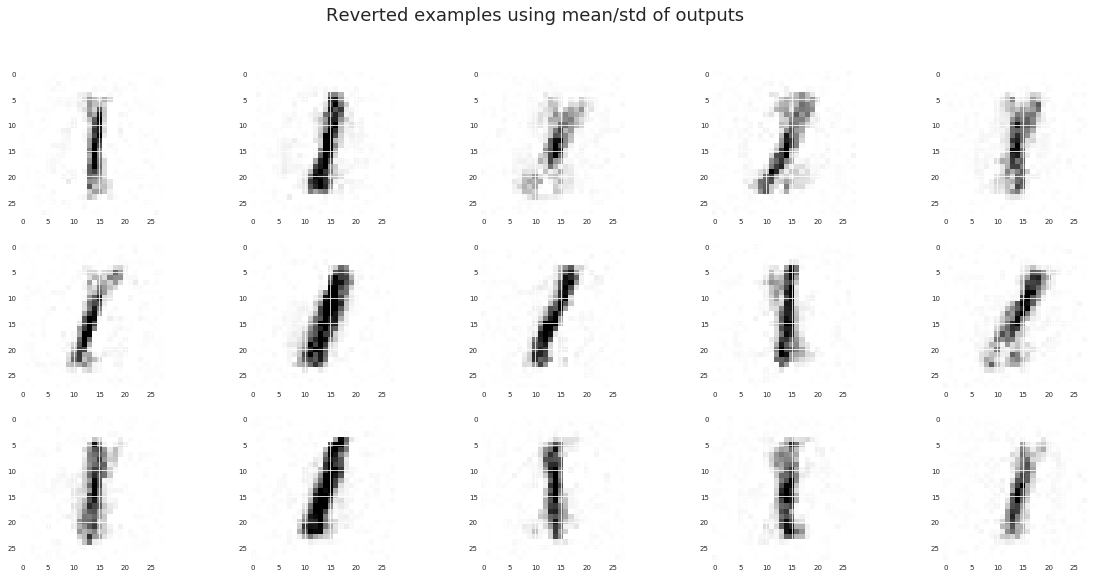

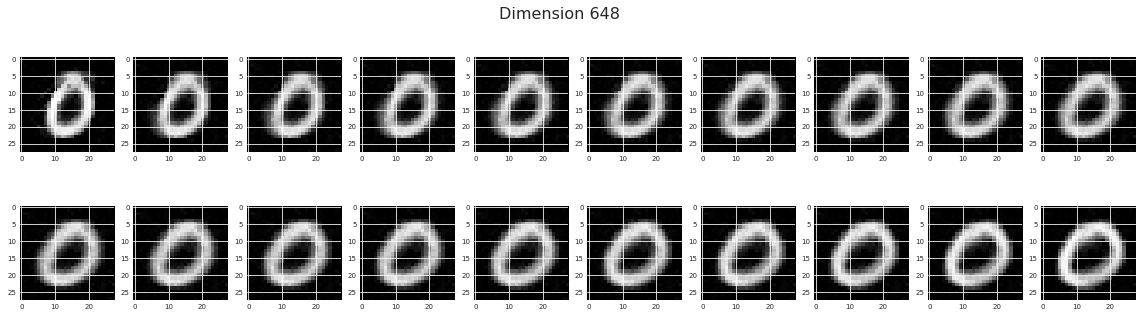

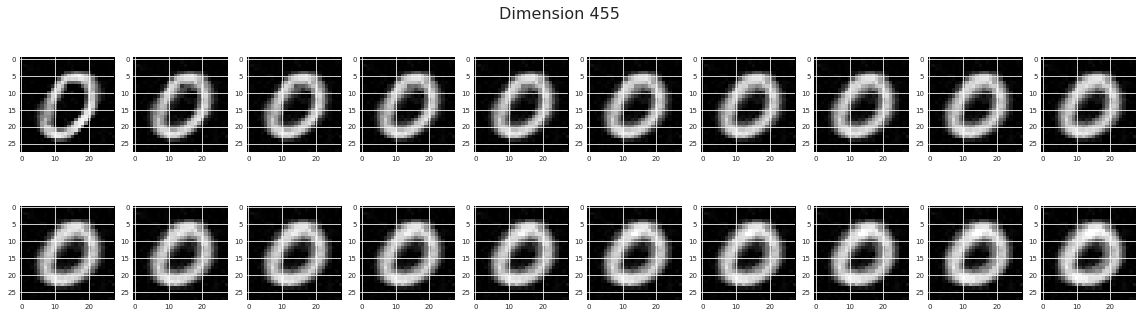

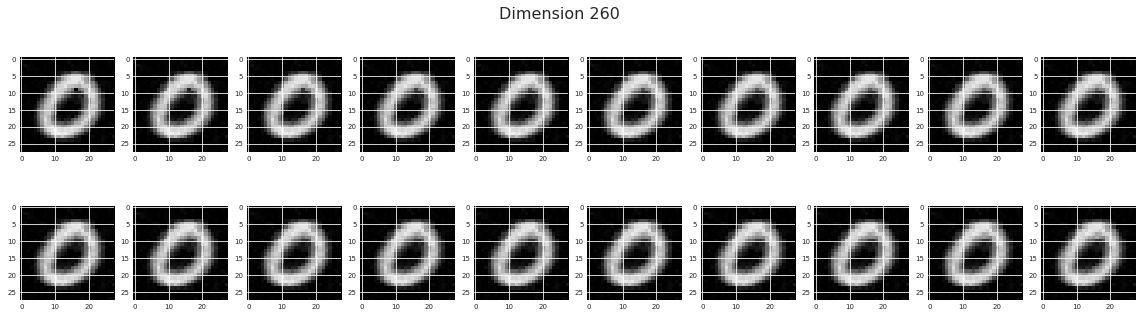

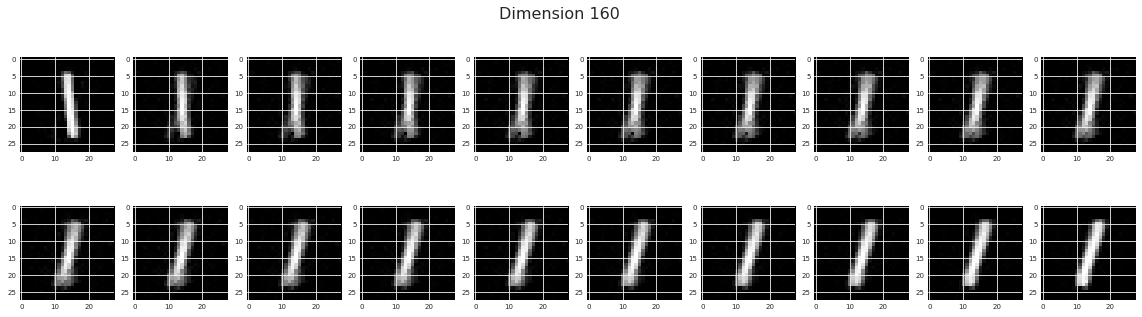

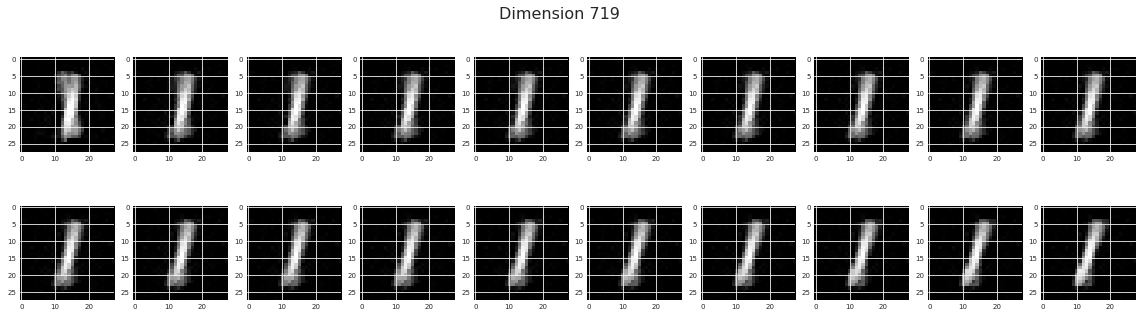

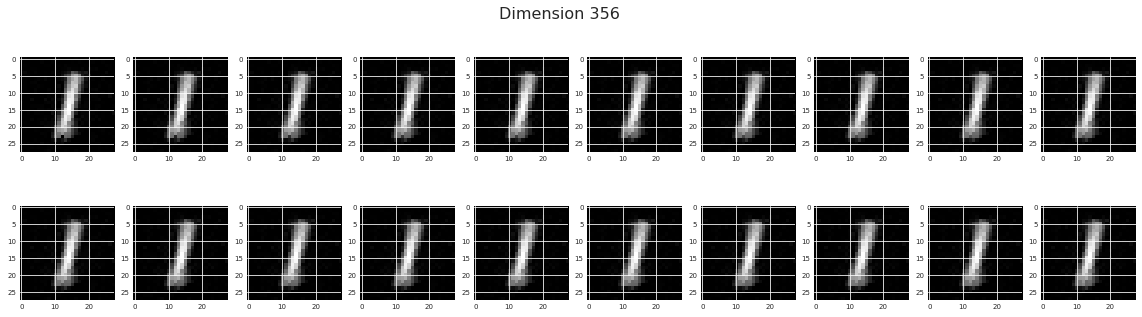

total_loss
910    1.483447

total_loss
920    1.409874

total_loss
930    1.403162

total_loss
940    1.370529

total_loss
950    1.357414

total_loss
960    1.353485

total_loss
970    1.325859

total_loss
980    1.297501

total_loss
990    1.280478

total_loss
1000    1.275003

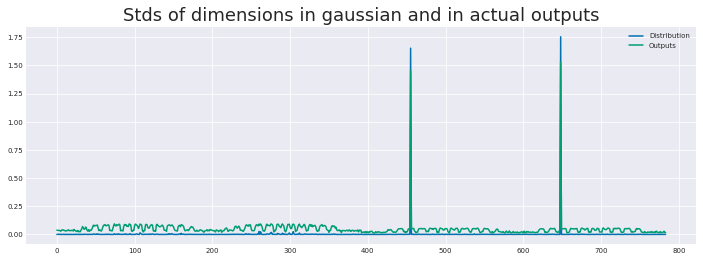

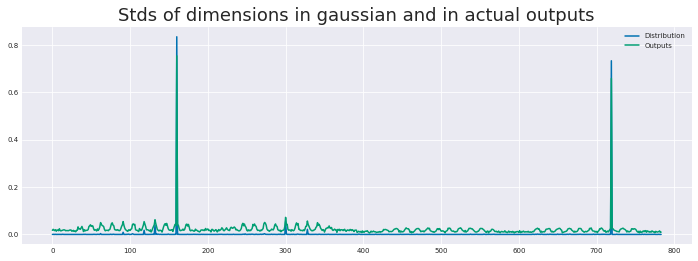

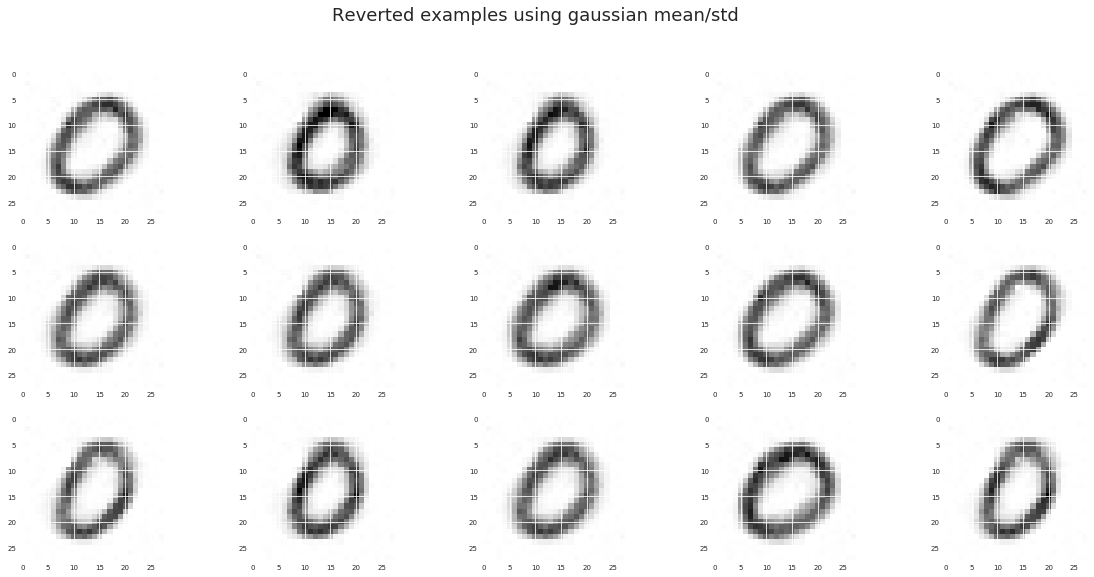

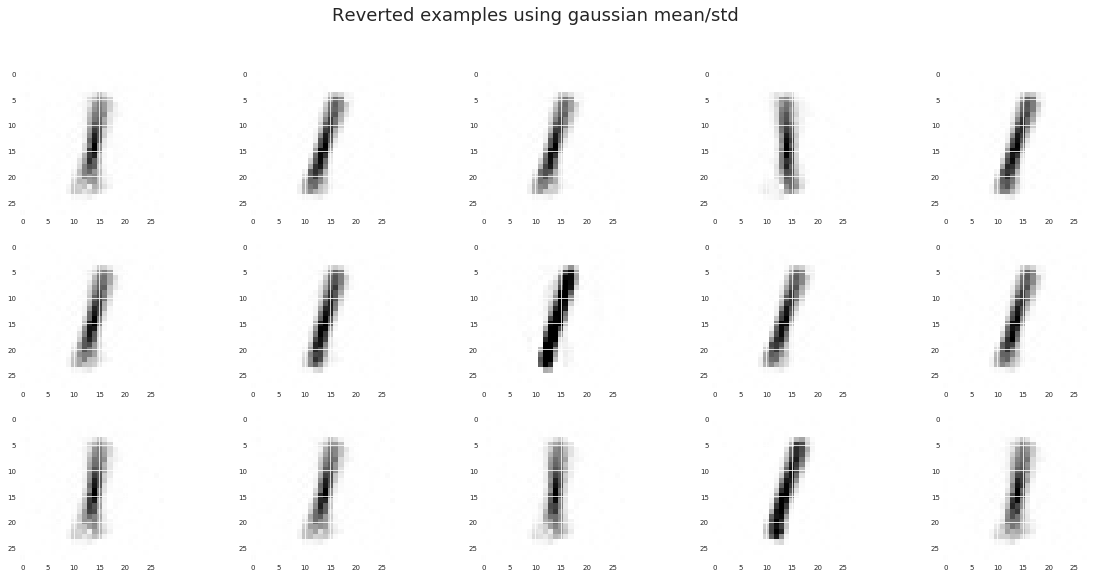

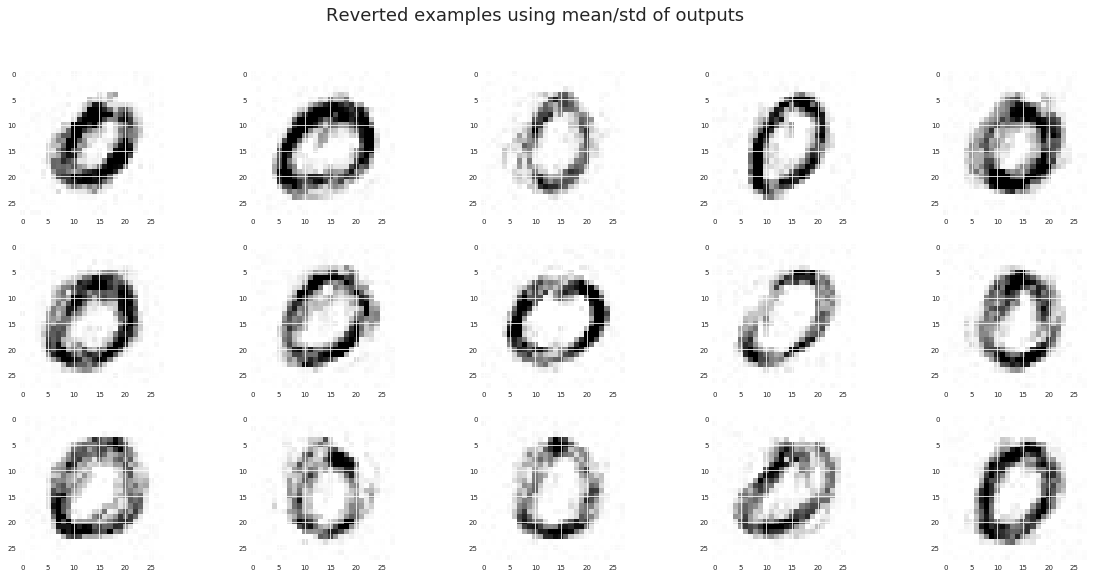

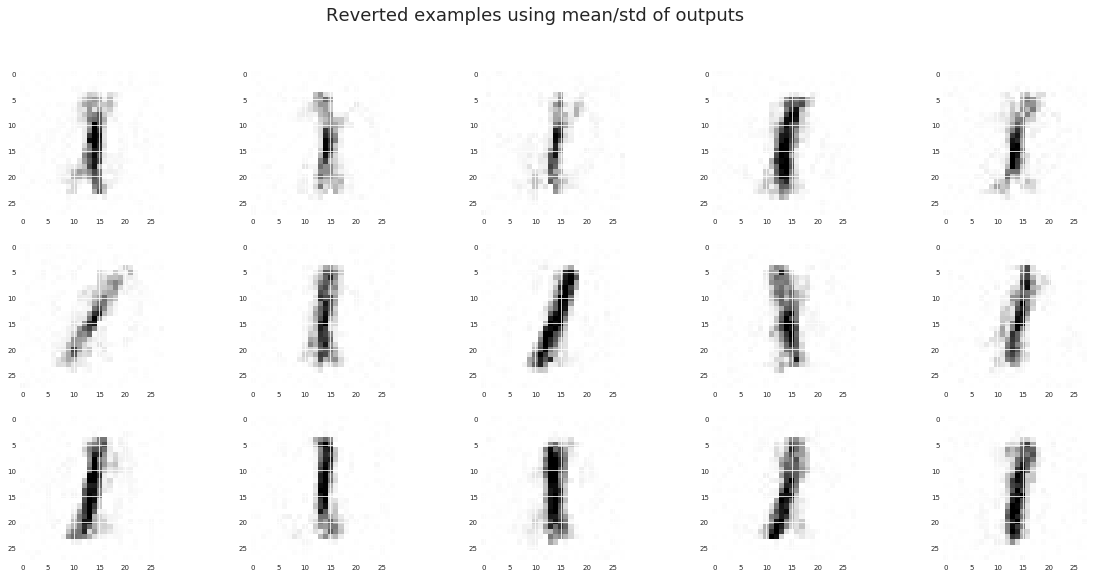

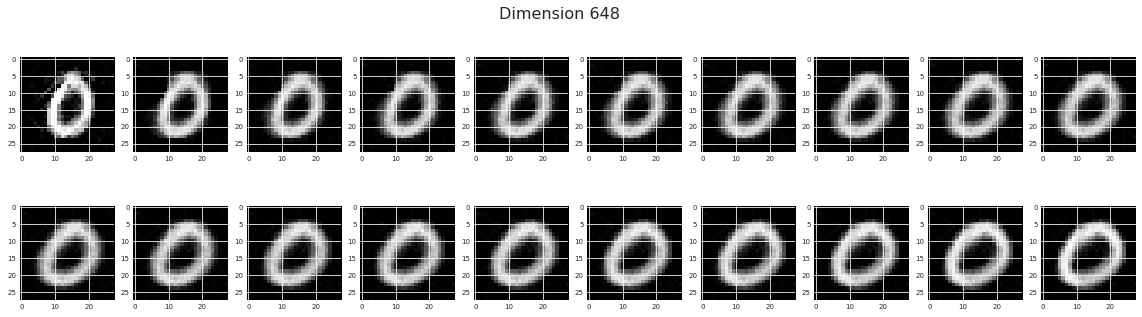

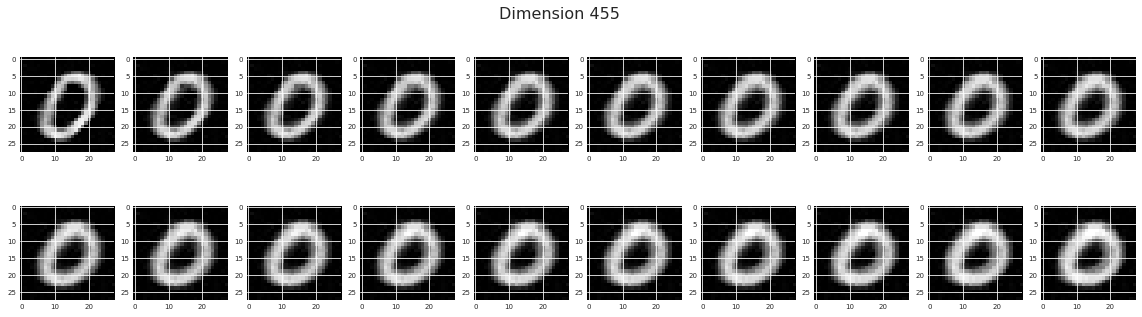

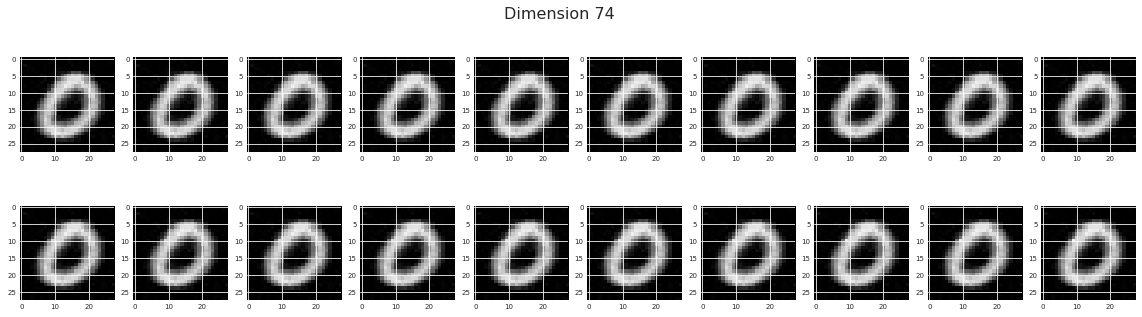

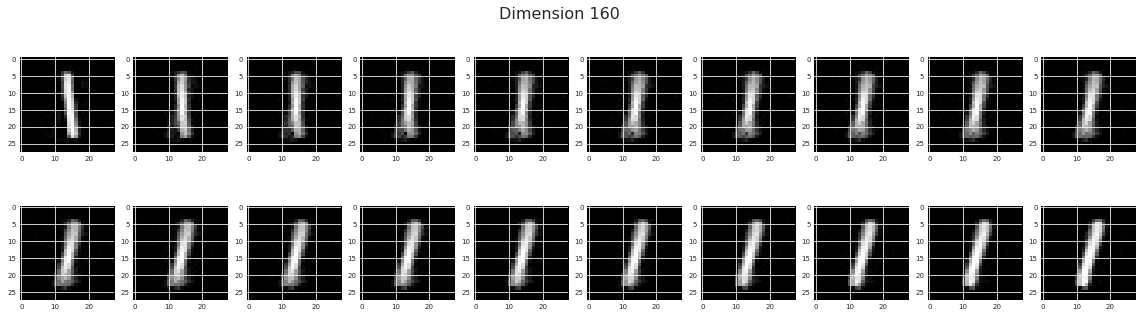

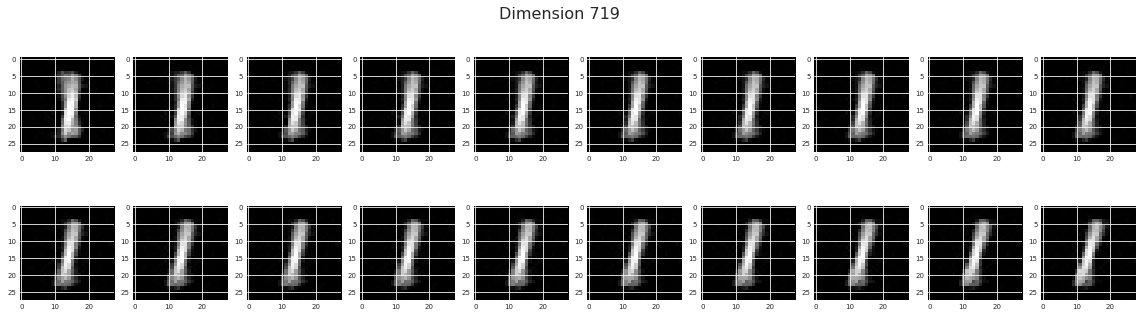

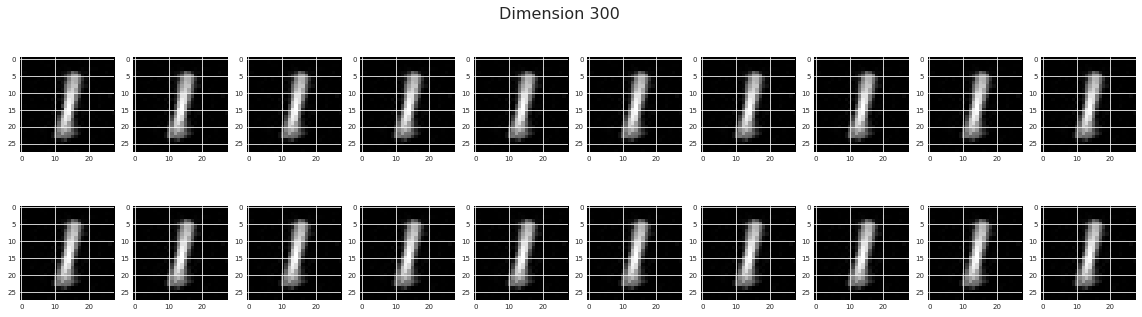

total_loss
1010    1.261571

total_loss
1020    1.234764

KeyboardInterrupt: 

In [12]:
import pandas as pd
from reversible.util import var_to_np
from reversible.revnet import get_inputs_from_reverted_samples

rng = RandomState(1)
epochs_dataframe = pd.DataFrame()
for i_epoch in range(100001):
    feature_model.train()
    for i_update in range(n_updates_per_epoch):
        if i_update % (n_critic_updates + 1) == n_critic_updates:
            # now run generator
            loss = train_one_batch(iterator, feature_model, loss_fn, means_per_dim, stds_per_dim, optimizer)
            stds_per_dim.data.clamp_(min=0)
        else:
            loss = train_one_batch(iterator, feature_model, loss_fn_adv, means_per_dim, stds_per_dim, optimizer_adv)
            stds_per_dim.data.clamp_(min=0) # should not be necessary...
    feature_model.eval()
    epochs_dataframe = epochs_dataframe.append({
        'total_loss': np.mean(loss),
    },
        ignore_index=True)
    if i_epoch % 10 == 0:
        display(epochs_dataframe.iloc[-1:])
    if i_epoch % 100 == 0:
        
        all_outs = feature_model(inputs)
        all_outs = var_to_np(all_outs).squeeze()
        
        for i_cluster in range(2):
            fig = plt.figure()
            plt.plot(var_to_np(stds_per_dim[i_cluster]))
            plt.plot(np.std(all_outs[y == i_cluster], axis=0))
            plt.legend(('Distribution', 'Outputs'))
            plt.title("Stds of dimensions in gaussian and in actual outputs", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(2):
            rec_examples, _ = get_inputs_from_reverted_samples(
                 len(inputs), means_per_dim[i_cluster:i_cluster+1], stds_per_dim[i_cluster:i_cluster+1],
                np_to_var([1,]), feature_model,
                to_4d=False)

            fig, axes = plt.subplots(3,5, figsize=(20,9))

            for i_example, ax in enumerate(axes.flatten()):
                ax.imshow(rec_examples[i_example].squeeze(), vmin=0, vmax=1, cmap=cm.Greys)
            fig.suptitle("Reverted examples using gaussian mean/std", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(len(means_per_dim)):
            mean =  np_to_var(np.mean(all_outs[y == i_cluster], axis=0, keepdims=True), dtype=np.float32).cuda()
            std = np_to_var(np.std(all_outs[y == i_cluster], axis=0, keepdims=True), dtype=np.float32).cuda()
            rec_examples, _ = get_inputs_from_reverted_samples(
                 len(inputs), mean, std,
                np_to_var([1,]), feature_model,
                to_4d=False)

            fig, axes = plt.subplots(3,5, figsize=(20,9))

            for i_example, ax in enumerate(axes.flatten()):
                ax.imshow(rec_examples[i_example].squeeze(), vmin=0, vmax=1, cmap=cm.Greys)
            fig.suptitle("Reverted examples using mean/std of outputs", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(2):
            stds = np.std(all_outs[y == i_cluster], axis=0)
            sorted_stds = np.argsort(stds)[::-1]
            for i_large_std in sorted_stds[:3]:
                stds_cloned = stds_per_dim.clone()
                stds_cloned = stds_cloned * 0
                stds_cloned[i_cluster,i_large_std] = float(stds[i_large_std])
                rec_examples, gauss_samples = get_inputs_from_reverted_samples(
                    1000, means_per_dim[i_cluster:i_cluster+1],
                    stds_cloned[i_cluster:i_cluster+1], np_to_var([1]), feature_model, to_4d=False)
                i_sort = np.argsort(var_to_np(gauss_samples)[:, i_large_std])
                sorted_examples = rec_examples[i_sort]
                sorted_examples = sorted_examples[::1000//20]
                fig = plot_sorted_examples(sorted_examples)
                fig.suptitle("Dimension {:d}".format(i_large_std), fontsize=16)
                display(fig)
                plt.close(fig)

In [ ]:
# discrete sag

